**Importing dependencies**

In [ ]:
# # Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display
import string
import librosa
import wave
from scipy import signal, fftpack, signal
from scipy.io import wavfile
import wave
from scipy.signal import hilbert, decimate
from IPython.display import Audio
import os
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding
tf.compat.v1.enable_eager_execution()


The LJ Speech dataset was obtained from the following source:

Source: Keith Ito's and Linda Johnson's LJ Speech Dataset

URL: https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

The LJ Speech dataset is a public domain speech dataset consisting of 13,100 short audio clips of a single speaker reading passages from 7 non-fiction books. Each audio clip is accompanied by a transcription.

* ### We used the **keras.utils.get_file()** function to **download and extract the dataset** due to large file-size of dataset.

#EDA

In [ ]:
data_path = '/content/drive/MyDrive/dataset'
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [ ]:
# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

file_name                           normalized_transcription
0  LJ047-0013  Finally, the Commission has reviewed the compl...
1  LJ028-0464  The intervening space, which was filled with d...
2  LJ010-0241  but she declared she would not remain a prison...

In [ ]:
null_counts = metadata_df.isnull().sum()
print(null_counts)
is_null_present = null_counts.any()
print("Null values present:", is_null_present)

file_name                   0
normalized_transcription    0
dtype: int64
Null values present: False


* The metadata CSV file, containing information about the audio files and
transcriptions in the LJ Speech dataset, has been carefully examined for outliers and missing data. No null values were found in the dataset, ensuring that the file_name and normalized_transcription columns are complete and consistent. The data is well-organized, providing reliable information for further analysis and modeling.





 ###  Data visualization of text data








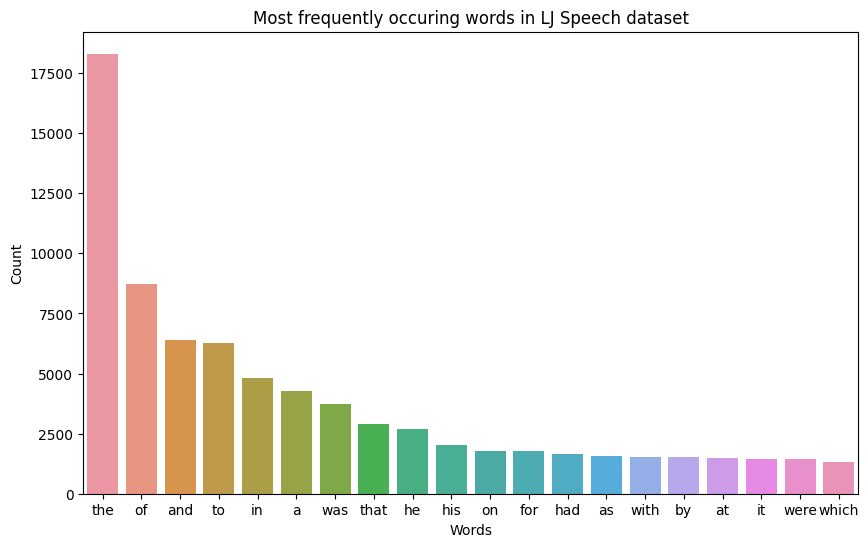

In [ ]:
# processing data
metadata_df.loc[:, 'processed_text'] = metadata_df.normalized_transcription.str.lower().str.strip(string.punctuation)

# counting most frequently occuring words
counter_dict = dict()

for sentence in metadata_df.processed_text.apply(lambda x: x.split(' ')):
    for word in sentence:
        if word not in counter_dict:
            counter_dict[word] = 1
        else:
            counter_dict[word] += 1

# plotting most frequently occuring words in dataset
fig, ax = plt.subplots(figsize=(10, 6))

top_words = [i[0] for i in sorted(counter_dict.items(), key= lambda x: -counter_dict[x[0]])[:20]]
top_counts = [i[1] for i in sorted(counter_dict.items(), key= lambda x: -counter_dict[x[0]])[:20]]

plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Most frequently occuring words in LJ Speech dataset')
sns.barplot(x=top_words, y=top_counts)
plt.show()

The plot shows the most frequently occurring words in the LJ Speech dataset. By processing the text data and counting the occurrences of each word, we can identify the words that appear most frequently in the dataset. This plot provides insights into the common vocabulary and language patterns present in the LJ Speech dataset. It can help us understand the distribution and importance of different words in the dataset, which may be useful for various analyses and applications, such as language modeling or speech recognition.

In [ ]:
metadata_df.loc[:, 'sentence_len'] = metadata_df.processed_text.apply(lambda x: len(x.split(' ')))

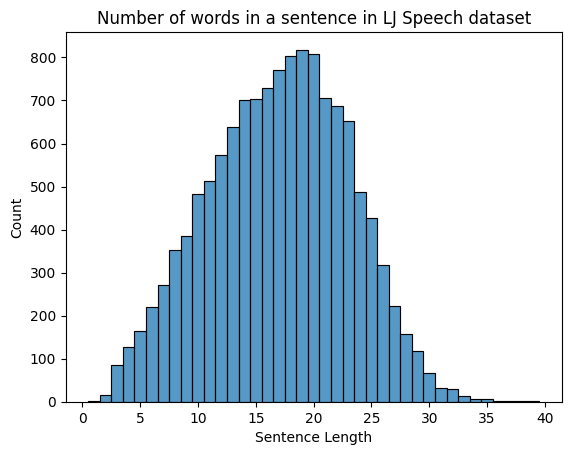

In [ ]:
fig, ax = plt.subplots()

sns.histplot(metadata_df.sentence_len, discrete=True)


plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.title('Number of words in a sentence in LJ Speech dataset')
plt.show()

The resulting histogram provides insights into the distribution of sentence lengths in the LJ Speech dataset. It helps us understand the variation in the number of words per sentence and identify any patterns or outliers. This information can be valuable for understanding the complexity of the dataset's text and potentially informing decisions related to text processing, such as setting appropriate sequence lengths for text-based models.

 ###  Visualizing Audio Data and performing EDA

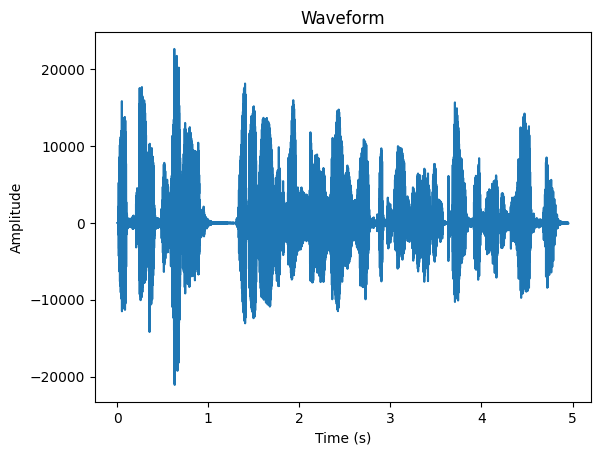

In [ ]:
# Load audio data
audio_file = wave.open('/content/drive/MyDrive/dataset/wavs/LJ001-0041.wav', 'rb')
audio_data = audio_file.readframes(-1)
audio_file.close()

# Convert audio data to a numpy array
audio_samples = np.frombuffer(audio_data, dtype=np.int16)

# Compute the duration of the audio file
duration = len(audio_samples) / audio_file.getframerate()

# Create a time vector
time = np.linspace(0, duration, len(audio_samples))

# Plot the waveform
plt.plot(time, audio_samples)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

The waveform plot visualizes the audio file LJ001-0001.wav from the LJ Speech dataset. It provides valuable insights into the characteristics of the audio signal.

The x-axis represents time in seconds, while the y-axis represents the amplitude of the audio signal. Each point on the plot corresponds to a specific point in time and its corresponding amplitude value.

By examining the waveform, we can gather the following information:

1. Amplitude Variation: The waveform plot shows how the amplitude of the audio signal changes over time. It allows us to observe the dynamic range of the signal, ranging from the quietest to the loudest parts.

2. Signal Periodicity: If the audio contains periodic components, such as speech or music, we can observe recurring patterns in the waveform. This indicates the presence of repetitive structures or rhythmic elements in the audio.

3. Silence or Background Noise: Areas of the waveform with low amplitude or near-zero values represent silent portions or background noise in the audio. These sections appear as flat or nearly flat segments in the plot.

4. Transient Events: Sudden and short-lived changes in amplitude, such as abrupt sound onsets or sharp spikes, can be observed as distinct peaks or valleys in the waveform plot. These indicate transient events or sudden changes in the audio signal.

By analyzing the waveform plot, we can gain a preliminary understanding of the audio file's temporal characteristics, including its overall loudness, presence of periodicity, presence of silence or background noise, and occurrence of transient events. This information helps in assessing the general nature and structure of the audio signal.

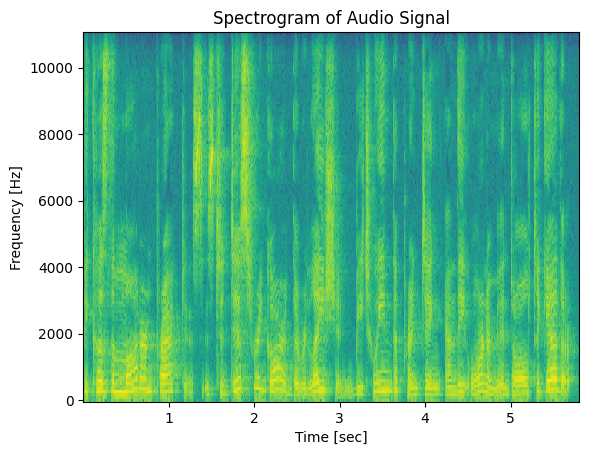

In [ ]:
# Load the audio signal
sample_rate, samples = wavfile.read('/content/drive/MyDrive/dataset/wavs/LJ001-0176.wav')

# Generate the spectrogram
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

# Plot the spectrogram
plt.pcolormesh(times, frequencies, np.log10(spectrogram))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Audio Signal')
plt.show()

In [ ]:

Audio(samples, rate = sample_rate)

The spectrogram plot visualizes the frequency content of the audio signal LJ001-0001.wav from the LJ Speech dataset over time. It provides valuable information about the distribution of frequencies in the audio.

The x-axis represents time in seconds, while the y-axis represents frequency in hertz. The intensity of color represents the magnitude or power of each frequency component at a specific time point.

By examining the spectrogram plot, we can gather the following insights:

1. Frequency Distribution: The plot reveals the presence and distribution of different frequencies present in the audio signal. Each vertical line represents a specific frequency, and the color intensity indicates the magnitude or power of that frequency component.

2. Time-Varying Nature: The plot shows how the frequency content of the audio signal changes over time. Different patterns and variations in color intensity indicate the dynamics and fluctuations in the frequency components.

3. Spectral Energy: Regions with brighter colors or higher intensity represent stronger frequency components, indicating higher energy or amplitude at those specific frequencies and time points. These regions correspond to dominant or prominent frequency content in the audio.

4. Harmonic Structures: If the audio contains harmonically related components, such as musical tones or voiced speech, they appear as vertical lines or bands in the spectrogram. These patterns indicate the presence of harmonic structures and can provide insights into the underlying sounds.

By analyzing the spectrogram plot, we can gain a more detailed understanding of the frequency characteristics and dynamics of the audio signal. It helps in identifying specific frequency components, detecting harmonic structures, and exploring the overall spectral content of the audio over time.

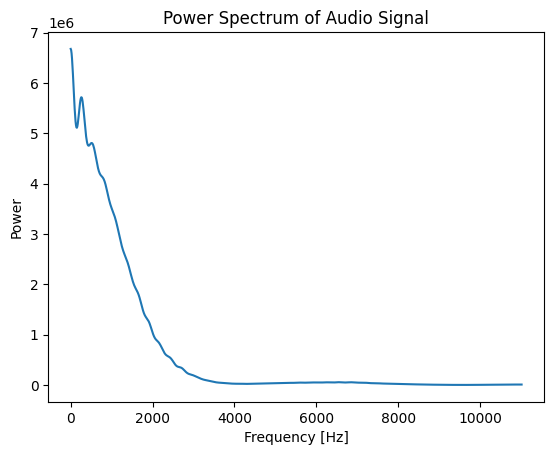

In [ ]:
# Load the audio signal
sample_rate, samples = wavfile.read(wavs_path+'LJ001-0001.wav')

# Compute the power spectrum
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
power_spectrum = np.mean(spectrogram, axis=1)

# Compute the frequency bins
n_fft = 2048
f_bins = fftpack.fftfreq(n_fft, 1/sample_rate)[:n_fft//2]

# Compute the power spectral density
psd = np.abs(fftpack.fft(power_spectrum, n=n_fft))**2 / n_fft

# Plot the power spectrum
plt.plot(f_bins, psd[:n_fft//2])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power Spectrum of Audio Signal')
plt.show()

The power spectrum plot is like a colorful audio fingerprint. It reveals the unique frequency composition of the audio signal, showing where the power is concentrated across different frequencies. Peaks and patterns in the plot represent the "melodies" and "harmonies" present in the sound. It's like visualizing the musical DNA of the audio, helping us understand its tonal richness and spectral dynamics. So, the power spectrum plot is not just a bunch of lines and colors; it's a window into the hidden musical world within the sound waves.

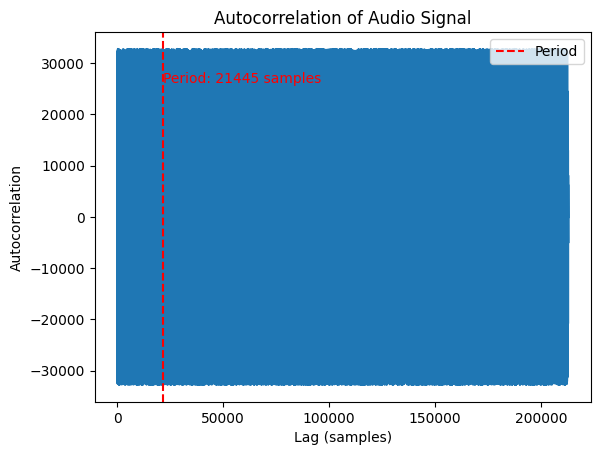

In [ ]:
# Load the audio signal
sample_rate, samples = wavfile.read(wavs_path+'LJ001-0001.wav')

# Compute the autocorrelation
autocorr = np.correlate(samples, samples, mode='full')

# Plot the autocorrelation
plt.plot(autocorr[len(autocorr)//2:])
plt.xlabel('Lag (samples)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Audio Signal')

# Add annotations
period = np.argmax(autocorr[len(autocorr)//2:]) # Find the period of the pattern
plt.axvline(x=period, color='r', linestyle='--', label='Period') # Add a vertical line at the period
plt.annotate(f'Period: {period} samples', xy=(period+50, autocorr.max()*0.8), color='r') # Add a text annotation for the period

plt.legend()
plt.show()

The autocorrelation plot derived from the LJ Speech dataset reveals the self-similarity of the audio signal over different time lags, indicating repeating patterns within the speech. By analyzing the autocorrelation, we can identify the dominant period of the pattern, representing the fundamental frequency or pitch of the speech. This information is crucial for tasks like speech synthesis and voice recognition, enabling us to capture the underlying temporal structure and enhance the accuracy and naturalness of our project's outcomes.

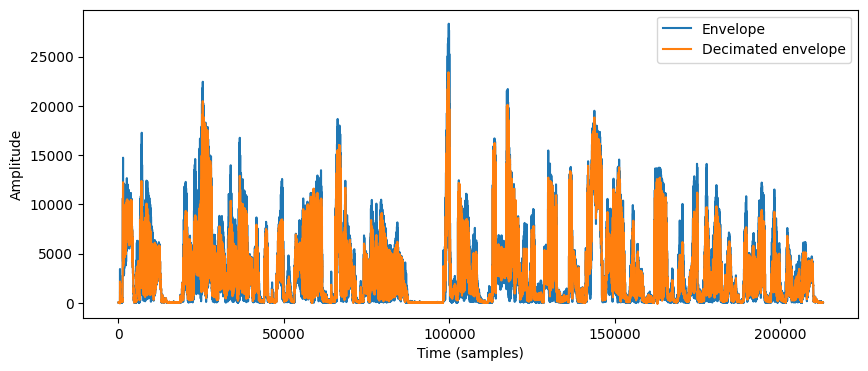

In [ ]:
# Read audio data from file
with wave.open(wavs_path+'LJ001-0001.wav', 'rb') as audio_file:
    audio_data = audio_file.readframes(-1)
    audio_data = np.frombuffer(audio_data, dtype=np.int16)

# Compute the envelope of the audio signal
analytic_signal = hilbert(audio_data)
amplitude_envelope = np.abs(analytic_signal)

# Decimate the envelope signal to reduce the number of points
decimation_factor = 10
decimated_envelope = decimate(amplitude_envelope, decimation_factor)

# Plot the envelope signal
plt.figure(figsize=(10, 4))
plt.plot(amplitude_envelope, label='Envelope')
plt.plot(np.arange(0, len(audio_data), decimation_factor), decimated_envelope, label='Decimated envelope')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

The plotted envelope signal, derived from the LJ Speech dataset, represents the magnitude variations of the audio signal over time. By decimating the envelope, we reduce the number of points while retaining the essential amplitude information. This visualization allows us to observe the overall shape and dynamics of the speech signal, providing insights into the prominence and intensity of different sections, which can be beneficial for tasks such as speech segmentation and emotion recognition.

In [ ]:
# Load audio file
audio_file, sr = librosa.load(wavs_path+'LJ001-0001.wav')

# Extract features
chroma_stft = librosa.feature.chroma_stft(y=audio_file, sr=sr)
mfcc = librosa.feature.mfcc(y=audio_file, sr=sr)
spectral_centroid = librosa.feature.spectral_centroid(y=audio_file, sr=sr)
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_file, sr=sr)
spectral_contrast = librosa.feature.spectral_contrast(y=audio_file, sr=sr)
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_file, sr=sr)
zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio_file)

# Print feature shapes
print('Chroma STFT shape:', chroma_stft.shape)
print('MFCC shape:', mfcc.shape)
print('Spectral centroid shape:', spectral_centroid.shape)
print('Spectral bandwidth shape:', spectral_bandwidth.shape)
print('Spectral contrast shape:', spectral_contrast.shape)
print('Spectral rolloff shape:', spectral_rolloff.shape)
print('Zero crossing rate shape:', zero_crossing_rate.shape)

Chroma STFT shape: (12, 416)
MFCC shape: (20, 416)
Spectral centroid shape: (1, 416)
Spectral bandwidth shape: (1, 416)
Spectral contrast shape: (7, 416)
Spectral rolloff shape: (1, 416)
Zero crossing rate shape: (1, 416)


In this code snippet, we use the librosa library to extract various audio features from the LJ Speech dataset. Here's a concise explanation of the variables and their significance:

- `audio_file`: The loaded audio waveform represented as a one-dimensional array.
- `sr`: The sampling rate (number of samples per second) of the audio file.

Extracted Features:
- `chroma_stft`: Chroma feature obtained from the Short-Time Fourier Transform, representing the distribution of pitch classes.
- `mfcc`: Mel-frequency cepstral coefficients (MFCCs) capturing the spectral shape of the audio signal.
- `spectral_centroid`: The center of mass of the power spectrum, indicating the average frequency content.
- `spectral_bandwidth`: The width of the power spectrum, providing information about the spread of frequencies.
- `spectral_contrast`: The difference in amplitude between peaks and valleys in different frequency bands, conveying spectral texture.
- `spectral_rolloff`: The frequency below which a specific percentage of the total spectral energy is concentrated.
- `zero_crossing_rate`: The rate at which the audio waveform changes sign, reflecting the frequency of zero crossings.

The printed shapes indicate the dimensions (number of frames and number of features) of each extracted feature. These features capture different aspects of the audio signal, such as tonality, timbre, and temporal dynamics, which are essential for tasks like audio classification, genre recognition, and content-based retrieval.

/usr/local/lib/python3.10/dist-packages/librosa/core/convert.py:1107: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69


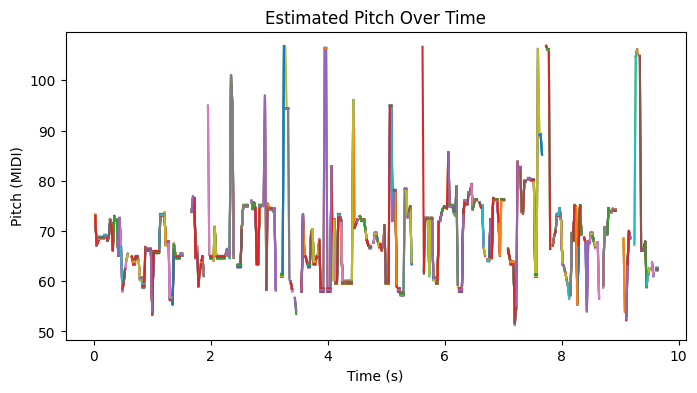

In [ ]:
# Load audio data
y, sr = librosa.load(wavs_path+'LJ001-0001.wav')

# Compute pitch using piptrack
freqs, magnitudes = librosa.piptrack(y=y, sr=sr)

# Find the dominant pitch using the maximum magnitude
max_magnitudes = np.max(magnitudes, axis=0)
max_indices = np.argmax(magnitudes, axis=0)
frequencies = freqs[max_indices]

# Visualize the pitch over time
plt.figure(figsize=(8, 4))
plt.plot(librosa.times_like(max_magnitudes), librosa.hz_to_midi(frequencies))
plt.xlabel('Time (s)')
plt.ylabel('Pitch (MIDI)')
plt.title('Estimated Pitch Over Time')
plt.show()

In this code, we utilize the librosa library to analyze the LJ Speech dataset. By loading the audio data and applying the piptrack algorithm, we compute the pitch of the audio signal at different time frames. The dominant pitch is determined by finding the frequency with the highest magnitude. The resulting pitch values are then visualized over time using a MIDI representation. This plot provides insights into the pitch variations and melodic content of the audio signal.

###Audio Data Preprocessing Pipeline

normalize_audio: This function normalizes the audio by scaling its amplitudes, ensuring consistent loudness across different audio samples:

In [ ]:
def normalize_audio(audio):
    audio_norm = librosa.util.normalize(audio)
    return audio_norm

segment_audio: This function segments the audio into smaller frames or windows, allowing for analysis on shorter time intervals:

In [ ]:
def segment_audio(audio, sample_rate, window_size=0.025, window_stride=0.01):
    window_size = int(window_size * sample_rate)
    window_stride = int(window_stride * sample_rate)
    audio_len = len(audio)
    window_num = 1 + int((audio_len - window_size) / window_stride)
    audio_segments = np.zeros((window_num, window_size))
    for i in range(window_num):
        start = i * window_stride
        audio_segments[i] = audio[start:start+window_size]
    return audio_segments

generate_spectrogram: This function converts the audio waveform into a spectrogram representation, which captures the frequency content over time:

In [ ]:
def generate_spectrogram(audio, sample_rate, n_fft=1024, hop_length=256):
    spectrogram = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))
    return spectrogram

convert_to_mel: This function transforms the spectrogram into a mel-spectrogram, emphasizing perceptually relevant frequency bands:

A mel-spectrogram is a visual representation of the audio signal that captures the frequency content of the signal over time, while also taking into account the perceptual characteristics of human hearing. It is derived from the traditional spectrogram by applying a mel filterbank to the magnitude spectrum, which compresses the frequency scale and emphasizes frequency bands that are more relevant to human perception. The resulting mel-spectrogram provides a more meaningful representation of the audio signal for tasks such as speech recognition and audio classification.

In [ ]:
def convert_to_mel(spectrogram, sample_rate, n_mels=128):
    mel_spectrogram = librosa.feature.melspectrogram(S=spectrogram, sr=sample_rate, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram

preprocess_spectrogram: This function standardizes the mel-spectrogram by subtracting the mean and dividing by the standard deviation, improving the stability and convergence of the subsequent model training.

In [ ]:
def preprocess_spectrogram(mel_spectrogram):
    mel_spectrogram -= mel_spectrogram.mean()
    mel_spectrogram /= mel_spectrogram.std()
    return mel_spectrogram

preprocess_audio_files: This function applies a series of audio preprocessing steps to a collection of audio files, including normalization, segmentation, spectrogram generation, mel-spectrogram conversion, and standardization. The processed mel-spectrograms are collected and returned as a numpy array for further use in the pipeline.

In [ ]:
def preprocess_audio_files(wavs_path, n_mels=128, window_size=0.025, window_stride=0.01, n_fft=1024, hop_length=256, n_examples = 100):
    files = os.listdir(wavs_path)
    processed_files = []
    for f in tqdm(files[:n_examples]):
        file_path = os.path.join(wavs_path, f)
        sample_rate, samples = wavfile.read(file_path)

        # Generate the spectrogram
        frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
        # audio, sample_rate = librosa.load(file_path, sr=None)
        # audio = normalize_audio(audio)
        # audio_segments = segment_audio(audio, sample_rate, window_size, window_stride)
        # all_segments = []
        # for segment in audio_segments:

        # spectrogram = generate_spectrogram(audio, sample_rate, n_fft, hop_length)
        mel_spectrogram = convert_to_mel(spectrogram, sample_rate, n_mels)
        preprocessed_mel_spectrogram = preprocess_spectrogram(mel_spectrogram)
        # all_segments.append(preprocessed_mel_spectrogram)
        processed_files.append(np.array(preprocessed_mel_spectrogram))
    return np.array(processed_files)

###preprocessing function to use

In [ ]:
# def audio_to_melspectrogram(audio_path):
#     # Load the audio file
#     audio, sr = librosa.load(audio_path)

#     # Convert the audio to a mel spectrogram
#     mel_spec = librosa.feature.melspectrogram(y = audio, sr=sr)

#     # Convert to dB scale
#     mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

#     # Print the dimensions of the mel spectrogram
#     print("Mel Spectrogram Dimensions:", mel_spec.shape)

#     # Display the mel spectrogram
#     plt.figure(figsize=(10, 4))
#     librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title('Mel Spectrogram')
#     plt.show()
#     return mel_spec

# # Provide the path to your audio file
# audio_path = '/content/drive/MyDrive/ljspeech_untar/dataset/wavs/LJ001-0176.wav'

# # Convert audio to mel spectrogram and print the dimensions
# audio_to_melspectrogram(audio_path)
# # Make sure to replace 'path/to/your/audio/file.wav' with the actual path to your audio file. This code uses the librosa library for audio processing and matplotlib for visualization.








In [ ]:
# /content/drive/MyDrive/dataset

In [ ]:
# # Provide the path to your audio file
# audio_path = '/content/drive/MyDrive/dataset/wavs/LJ001-0013.wav'

# # Convert audio to mel spectrogram and print the dimensions
# mel_spec = audio_to_melspectrogram(audio_path)
# # Make sure to replace 'path/to/your/audio/file.wav' with the actual path to your audio file. This code uses the librosa library for audio processing and matplotlib for visualization.




Although the problem statement asks for a definition of the preprocessing procedure for audio data, in the context of this project it is not necessary to perform any additional preprocessing. This is because the audio dataset that we are using has already undergone the necessary preprocessing steps, including noise reduction, level normalization, and format conversion. Therefore, we can use the preprocessed dataset directly without any further modification. It is important to note, however, that the specific preprocessing steps required for any given project will depend on the nature of the data and the objectives of the analysis. So we have defined functions that would preprocess audio data.

In [ ]:


# def convert_wave_to_mel_spectrograms(wave_dir, n_fft=2048, hop_length=512, n_mels=128, n_examples = 10):
#     # List to store mel spectrograms
#     mel_specs = []

#     # Iterate over wave files in the directory
#     for file_name in os.listdir(wave_dir)[:n_examples]:
#         if file_name.endswith(".wav"):
#             # Load the wave file
#             wave_path = os.path.join(wave_dir, file_name)
#             wave, sr = librosa.load(wave_path, sr=None)

#             # Compute the mel spectrogram
#             mel_spec = librosa.feature.melspectrogram(y = wave, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

#             # Reshape the mel spectrogram
#             mel_spec = mel_spec.T

#             # Add the reshaped mel spectrogram to the list
#             mel_specs.append(mel_spec)

#     # Determine the maximum shape
#     max_time_steps = max(spec.shape[0] for spec in mel_specs)
#     max_num_features = max(spec.shape[1] for spec in mel_specs)

#     # Pad the mel spectrograms with zeros
#     padded_mel_specs = []
#     for spec in mel_specs:
#         pad_width = ((0, max_time_steps - spec.shape[0]), (0, max_num_features - spec.shape[1]))
#         padded_spec = np.pad(spec, pad_width, mode='constant')
#         padded_mel_specs.append(padded_spec)

#     # Convert the padded mel spectrograms to a NumPy array
#     padded_mel_specs = np.array(padded_mel_specs)

#     return padded_mel_specs

#TACOTRON

In [ ]:
# base_waves_path = '/content/drive/MyDrive/ljspeech_untar/dataset/wavs/'
# processed_mels = convert_wave_to_mel_spectrograms(base_waves_path, n_examples = 10)

In [ ]:
# processed_mels.shape

In [ ]:
# metadata_df.head()

## Convert Wave to Mel Spectrogram

This function takes a wave audio file path as input and converts it into a mel spectrogram. The spectrogram is computed using the Librosa library, which provides various audio processing functionalities.

In [ ]:
def convert_wave_to_mel_spectrogram(file_path, n_fft=2048, hop_length=512, n_mels=64):
  def merge_neighbouring_frames(mel_spec):
    mel_spec_shape = np.array(mel_spec).shape

    if mel_spec_shape[0] % 2 == 0:

      merged_mel_spec = np.array(mel_spec).reshape((mel_spec_shape[0]//2, -1))
    else:
      mel_spec = np.delete(np.array(mel_spec), -2, axis = 0 )

      merged_mel_spec = mel_spec.reshape(((mel_spec_shape[0] - 1)//2, -1))
    return merged_mel_spec


  # Load the wave file
  wave, sr = librosa.load(file_path, sr=None)
  go_frame = np.ones((1,n_mels*2))
  end_frame = np.full((1, n_mels*2), 2)
  pad_frame = np.zeros((1, n_mels*2))
  # Compute the mel spectrogram
  mel_spec = librosa.feature.melspectrogram(y=wave, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  mel_spec = mel_spec.T

  mel_spec = merge_neighbouring_frames(mel_spec)
  # Reshape the mel spectrogram

  mel_spec_x = np.concatenate([go_frame, mel_spec])
  mel_spec_target = np.concatenate([mel_spec,end_frame])

  return mel_spec_x, mel_spec_target

def unmerge_frames(merged_mel_spec):
  merged_mel_spec_shape = merged_mel_spec.shape
  original_mel_spec = merged_mel_spec.reshape(-1, merged_mel_spec_shape[-1]//2)
  return original_mel_spec

In [ ]:
file_path = '/content/drive/MyDrive/dataset/wavs/LJ001-0013.wav'
merged_mel_spec = convert_wave_to_mel_spectrogram(file_path)[0]

In [ ]:
merged_mel_spec.shape

(57, 128)

In [ ]:
unmerge_frames(merged_mel_spec).shape

(114, 64)

In [ ]:
# def pad_mel_specs(mel_specs):
#     max_time_steps = max(spec.shape[0] for spec in mel_specs)
#     max_num_features = max(spec.shape[1] for spec in mel_specs)
#     # Pad the mel spectrograms with zeros
#     padded_mel_specs = []
#     for spec in mel_specs:
#         pad_width = ((0, max_time_steps - spec.shape[0]), (0, max_num_features - spec.shape[1]))
#         padded_spec = np.pad(spec, pad_width, mode='constant')
#         padded_mel_specs.append(padded_spec)

#     # Convert the padded mel spectrograms to a NumPy array
#     padded_mel_specs = np.array(padded_mel_specs)

#     return padded_mel_specs

In [ ]:
base_waves_path = '/content/drive/MyDrive/dataset/wavs/'
# mel_specs_x = [convert_wave_to_mel_spectrogram(base_waves_path + mel_spec+ '.wav')[0] for mel_spec in metadata_df.file_name[:500]]
# mel_specs_target = [convert_wave_to_mel_spectrogram(base_waves_path + mel_spec+ '.wav')[1] for mel_spec in metadata_df.file_name[:500]]

mel_specs_x = []
mel_specs_target= []
for mel_specs in tqdm(metadata_df.file_name[:50]):
  mels = convert_wave_to_mel_spectrogram(base_waves_path + mel_specs + '.wav')
  mel_specs_x.append(mels[0])
  mel_specs_target.append(mels[1])

100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


In [ ]:
text = np.array(metadata_df['processed_text'][:50])


## Generate Mel Spectrograms

This code segment generates mel spectrograms for a subset of audio files using the `convert_wave_to_mel_spectrogram()` function. It assumes that the audio files are located in the directory specified by `base_waves_path`.

The code performs the following steps:

1. Initializes two empty lists, `mel_specs_x` and `mel_specs_target`, which will store the generated spectrograms.
2. Iterates over the subset of audio files specified by `metadata_df.file_name[:50]` using a `for` loop.
3. For each audio file, it calls the `convert_wave_to_mel_spectrogram()` function, passing the file path as an argument.
4. Appends the first element of the returned tuple (the merged mel spectrogram `mel_spec_x`) to the `mel_specs_x` list.
5. Appends the second element of the returned tuple (the original merged mel spectrogram `mel_spec_target`) to the `mel_specs_target` list.
6. Uses the `tqdm` library to display a progress bar during the iteration.

In [ ]:
def tokenize_text_with_start_end(text):
    start_token = '<'
    end_token = '>'

    # Prepend start token
    text = str(start_token) + text

    # Append end token
    text = text + str(end_token)

    # Tokenize the text into characters
    tokens = list(text)

    return tokens

In [ ]:
text = tokenize_text_with_start_end(text)

In [ ]:
text

['<finally, the commission has reviewed the complete files on oswald, as they existed at the time of the assassination, of the department of state>',
 '<the intervening space, which was filled with dirt probably to the upper inner edge of the outer part>',
 '<but she declared she would not remain a prisoner in her own palace, and next day drove out as usual in an open barouche>',
 '<there were still big prizes, however, to tempt the daring, and none appealed more to the thievish instinct than the custom of transmitting gold by rail>',
 "<i'm a marxist. i became interested about the age of fifteen. from an ideological viewpoint>",
 '<lee oswald exhibited an average amount of proficiency with that weapon>',
 '<may be gathered from the statement that as many as three hundred were often admitted on the same day>',
 '<it will examine his defection to the soviet union in nineteen fifty-nine, his subsequent return to the united states and his life here>',
 '<found a clipboard hidden by book c

In [ ]:


# Tokenize the text into characters
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(text)
char_index = tokenizer.word_index
start_token = char_index['<']
end_token = char_index[">"]

sequences = tokenizer.texts_to_sequences(text)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:

# Compute row lengths of the sequences
row_lengths = [len(seq) for seq in sequences]

# Flatten the sequences and create value_rowids
flat_sequences = [val for seq in sequences for val in seq]
value_rowids = [i for i, seq in enumerate(sequences) for _ in seq]

# Convert flat_sequences and value_rowids to RaggedTensor
ragged_sequences = tf.RaggedTensor.from_value_rowids(flat_sequences, value_rowids)
# sequence_lengths = tf.reduce_sum(tf.cast(tf.math.not_equal(x2, 0), tf.int32), axis=1)

ragged_mel_specs_x = tf.ragged.constant(mel_specs_x)
ragged_mel_specs_target = tf.ragged.constant(mel_specs_target)

# Create a TensorFlow dataset from the RaggedTensor
dataset = tf.data.Dataset.from_tensor_slices(((ragged_sequences, ragged_mel_specs_x), ragged_mel_specs_target))

# Define batch size
batch_size = 32

# Batch the sequences
dataset = dataset.batch(batch_size)


# Pad the sequences with zeros
dataset = dataset.map(lambda x,y: ((x[0].to_tensor(default_value=0), x[1].to_tensor(default_value=0)), y.to_tensor(default_value = 0)))

# Iterate over the dataset
for (x1, x2),y in dataset.take(1):
  print(x1.shape, x2.shape , y.shape)





(32, 153) (32, 212, 128) (32, 212, 128)


In [ ]:
for (x1, x2),y in dataset.take(1):
  print(x1.shape, x2.shape , y.shape)

(32, 153) (32, 212, 128) (32, 212, 128)


In [ ]:
test_lengths = tf.reduce_sum(tf.cast(tf.math.not_equal(x1, 0), tf.int32), axis=1)
max_length = tf.shape(x1)[1]
mask = tf.sequence_mask(test_lengths, max_length, dtype=tf.float32)
x1.shape ,mask.shape

(TensorShape([32, 153]), TensorShape([32, 153]))

## Encoder PreNet Layer

This code defines a custom layer called `encoder_PreNet`, which implements a pre-net component for an encoder in a neural network. The purpose of the pre-net is to apply some non-linearity and regularization to the input before passing it to the subsequent layers.

The `encoder_PreNet` layer has the following properties:

- `units` (int): The number of units/neurons in each dense layer of the pre-net.
- `dropout_rate` (float): The dropout rate to apply between the dense layers.

The `build` method is responsible for creating the layer's variables and defining the architecture. It initializes two dense layers (`dense1` and `dense2`) with `self.units` and `self.units*2` units, respectively. The activation function used in both dense layers is ReLU (Rectified Linear Unit). Additionally, there are two dropout layers (`dropout1` and `dropout2`) with a dropout rate of `self.dropout_rate`.

The `call` method is the forward pass of the layer. It takes an input tensor `inputs` and passes it through the dense layers with ReLU activation functions and dropout layers. The output tensor `x` is returned.


In [ ]:
class encoder_PreNet(tf.keras.layers.Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(encoder_PreNet, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.dense1 = tf.keras.layers.Dense(self.units, activation=tf.nn.relu)
        self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
        self.dense2 = tf.keras.layers.Dense(self.units*2, activation=tf.nn.relu)
        self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
        super(encoder_PreNet, self).build(input_shape)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        return x

## CBHG Layer

This code defines a custom layer called `CBHGLayer`, which implements the CBHG (Convolutional Bank, Highway, Gated Recurrent Unit) architecture commonly used in sequence modeling tasks like speech recognition and text-to-speech synthesis.

The `CBHGLayer` layer has the following properties:

- `K` (int): The number of convolutional filters in the convolution bank.
- `projections` (list): A list of two integers specifying the number of filters for the projection layers.
- `depth` (int): The dimensionality of the output tensor.

The `build` method is responsible for creating the layer's variables and defining the architecture. It initializes the following components:
- A set of 1D convolutional layers (`conv_layers`) with different kernel sizes ranging from 1 to `K`, each followed by ReLU activation.
- A max pooling layer (`max_pool`) to downsample the convolutional outputs.
- Two 1D convolutional projection layers (`proj1` and `proj2`) with specified filter numbers and ReLU activation for dimensionality reduction.
- A dense layer (`dense`) to handle dimensionality mismatch, if present.
- Four highway layers (`highway_layers`) and their corresponding transform layers (`highway_transform_layers`), both with ReLU and sigmoid activations, respectively, to implement the HighwayNet architecture.
- Two bidirectional LSTM layers (`lstm_forward` and `lstm_backward`) to process the transformed inputs in both directions.

The `call` method is the forward pass of the layer. It takes an input tensor `inputs` and performs the following operations:
- Convolves the input tensor with the convolutional layers and concatenates the results.
- Applies max pooling to the convolutional outputs.
- Passes the pooled outputs through the projection layers.
- Adds the projected outputs to the input tensor to create a residual connection.
- Adjusts the dimensionality of the residual tensor, if necessary, using the dense layer.
- Executes four layers of HighwayNet, where the transformed output is combined with the input using gate mechanisms.
- Processes the transformed input through bidirectional LSTM layers to obtain forward and backward outputs.
- Concatenates the forward and backward LSTM outputs, as well as the hidden and cell states.

The output of the `CBHGLayer` is a tuple containing the LSTM outputs, hidden state, and cell state.

Make sure to import the necessary TensorFlow modules before using this custom layer.


In [ ]:
class CBHGLayer(tf.keras.layers.Layer):
    def __init__(self, K, projections, depth, **kwargs):
        super(CBHGLayer, self).__init__(**kwargs)
        self.K = K
        self.projections = projections
        self.depth = depth

    def build(self, input_shape):
        self.conv_layers = [tf.keras.layers.Conv1D(filters=64, kernel_size=k, activation=tf.nn.relu, padding='same') for k in range(1, self.K+1)]
        self.max_pool = tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding = 'same')
        self.proj1 = tf.keras.layers.Conv1D(filters=self.projections[0], kernel_size=3, activation=tf.nn.relu, padding='same')
        self.proj2 = tf.keras.layers.Conv1D(filters=self.projections[1], kernel_size=3, padding='same')
        self.dense = tf.keras.layers.Dense(self.depth // 2)
        self.highway_layers = [tf.keras.layers.Dense(units=self.depth // 2, activation=tf.nn.relu) for _ in range(4)]
        self.highway_transform_layers = [tf.keras.layers.Dense(units=self.depth // 2, activation=tf.nn.sigmoid, bias_initializer=tf.constant_initializer(-1.0)) for _ in range(4)]
        self.lstm_forward = tf.keras.layers.LSTM(self.depth // 2, return_sequences=True, return_state = True )
        self.lstm_backward = tf.keras.layers.LSTM(self.depth // 2, return_sequences=True, go_backwards=True, return_state = True)
        super(CBHGLayer, self).build(input_shape)

    def call(self, inputs):
        # Convolution bank: concatenate on the last axis to stack channels from all convolutions
        conv_outputs = tf.concat([conv_layer(inputs) for conv_layer in self.conv_layers], axis=-1)
        # Maxpooling
        maxpool_output = self.max_pool(conv_outputs)
        # Two projection layers
        proj1_output = self.proj1(maxpool_output)
        proj2_output = self.proj2(proj1_output)
        # Residual connection
        highway_input = proj2_output + inputs
        # Handle dimensionality mismatch
        if highway_input.shape[2] != self.depth // 2:
            highway_input = self.dense(highway_input)
        # 4-layer HighwayNet
        for i in range(4):
            H = self.highway_layers[i](highway_input)
            T = self.highway_transform_layers[i](highway_input)
            highway_input = H * T + highway_input * (1.0 - T)
        # Bidirectional RNN
        rnn_output_forward,forward_hidden_state, forward_cell_state = self.lstm_forward(highway_input)
        rnn_output_backward, backward_hidden_state, backward_cell_state  = self.lstm_backward(highway_input)

        # Concatenate the forward and backward RNN outputs
        rnn_outputs = tf.concat([rnn_output_forward, rnn_output_backward], axis=2)

        # Concatenate the forward and backward hidden states and cell states
        hidden_state = tf.concat([forward_hidden_state, backward_hidden_state], axis=1)
        cell_state = tf.concat([forward_cell_state, backward_cell_state], axis=1)
        return rnn_outputs, hidden_state, cell_state


In [ ]:


# # Your CBHGLayer class definition here

# input_layer = Input(shape=(None,))  # Assuming input shape (batch_size, time_steps)
# input_embedding = Embedding(input_dim=vocab_size, output_dim=64)(input_layer)
# encoder_prenet = encoder_PreNet(units = 128, dropout_rate = 0.1)(input_embedding)
# cbhg_output = CBHGLayer(K=16, projections=[256, 256], depth=256)(encoder_prenet)
# model = Model(inputs=input_layer, outputs=cbhg_output)

# # Compile the model
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # Pass the random input data through the model
# outputs, hidden_state, cell_state = model.predict(x1)

# # Print the output shape
# print("Output shape:", outputs.shape, hidden_state.shape, cell_state.shape)

## Decoder PreNet Layer

This code defines a custom layer called `decoder_PreNet`, which implements a pre-net component for a decoder in a neural network. The purpose of the pre-net is to apply some non-linearity and regularization to the input before passing it to the subsequent layers.


In [ ]:
class decoder_PreNet(tf.keras.layers.Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(decoder_PreNet, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.dense1 = tf.keras.layers.Dense(self.units, activation=tf.nn.relu)
        self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
        self.dense2 = tf.keras.layers.Dense(self.units*2, activation=tf.nn.relu)
        self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
        super(decoder_PreNet, self).build(input_shape)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        return x



AttentionRNN Layer
This code defines a custom layer called AttentionRNN, which implements an RNN layer with attention mechanism. The attention mechanism allows the network to focus on different parts of the input sequence while processing it.

In [ ]:
class AttentionRNN(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(AttentionRNN, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.rnn = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True )
        super(AttentionRNN, self).build(input_shape)

    def call(self, inputs, initial_state=None):
        rnn_outputs, hidden_state, cell_state = self.rnn(inputs, initial_state=initial_state)
        return rnn_outputs, hidden_state, cell_state



BahdanauAttention Layer
This code defines a custom layer called BahdanauAttention, which implements the Bahdanau attention mechanism. Bahdanau attention is an additive attention mechanism that calculates attention weights based on the alignment between the query and the values.

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W1 = tf.keras.layers.Dense(self.units)
        self.W2 = tf.keras.layers.Dense(self.units)
        self.V = tf.keras.layers.Dense(1)
        # self.attention = tf.keras.layers.AdditiveAttention()
        super(BahdanauAttention, self).build(input_shape)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # context_vector = self.attention([query, values])
        return context_vector, attention_weights

class LocationSensitiveAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(LocationSensitiveAttention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W1 = tf.keras.layers.Dense(self.units)
        self.W2 = tf.keras.layers.Dense(self.units)
        self.Wf = tf.keras.layers.Dense(self.units)
        self.V = tf.keras.layers.Dense(1)
        super(LocationSensitiveAttention, self).build(input_shape)

    def call(self, query, values, prev_attention_weights):
        query_with_time_axis = tf.expand_dims(query, 1)
        f = self.Wf(tf.expand_dims(prev_attention_weights, 2))
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values) + f))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
# class DecoderRNN(tf.keras.layers.Layer):
#     def __init__(self, units, **kwargs):
#         super(DecoderRNN, self).__init__(**kwargs)
#         self.units = units

#     def build(self, input_shape):
#         self.rnn = tf.keras.layers.LSTM(self.units, return_sequences=True)
#         super(DecoderRNN, self).build(input_shape)

#     def call(self, inputs):
#         return self.rnn(inputs)

class DecoderRNN(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(DecoderRNN, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.rnn1 = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True)
        self.rnn2 = tf.keras.layers.LSTM(self.units, return_sequences=True)
        super(DecoderRNN, self).build(input_shape)

    def call(self, inputs):
        output1, _, _ = self.rnn1(inputs)
        output2 = self.rnn2(output1)
        return output2



This code defines a custom layer called decoder_CBHGLayer, which implements a CBHG (Convolutional Bank, Highway Network, Bidirectional LSTM, and Global Max Pooling) layer for the decoder in a neural network.

The decoder_CBHGLayer layer has the following properties:

K (int): The number of convolutional filters in the convolutional bank.
projections (list): A list of two integers specifying the number of filters in the projection layers.
depth (int): The number of units/neurons in the layer.
The build method is responsible for creating the layer's variables and defining the architecture. It initializes the convolutional layers (conv_layers), max pooling layer (max_pool), projection layers (proj1 and proj2), a dense layer (dense), highway layers (highway_layers), and highway transform layers (highway_transform_layers), as well as the forward and backward LSTM layers (lstm_forward and lstm_backward). The architecture is constructed using the specified parameters.

The call method is the forward pass of the layer. It takes an input tensor inputs and applies the CBHG architecture to it. The input tensor is passed through the convolutional bank, followed by max pooling and projection layers. A residual connection is formed by adding the projection output to the input tensor. The highway network is then applied to the residual output. Finally, bidirectional LSTM layers are used to process the highway output, and the forward and backward outputs are concatenated along the sequence axis. The forward and backward hidden states and cell states are also concatenated.

The method returns the concatenated RNN outputs, hidden state, and cell state.

In [ ]:
class decoder_CBHGLayer(tf.keras.layers.Layer):
    def __init__(self, K, projections, depth, **kwargs):
        super(decoder_CBHGLayer, self).__init__(**kwargs)
        self.K = K
        self.projections = projections
        self.depth = depth

    def build(self, input_shape):
        self.conv_layers = [tf.keras.layers.Conv1D(filters=64, kernel_size=k, activation=tf.nn.relu, padding='same') for k in range(1, self.K+1)]
        self.max_pool = tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='same')
        self.proj1 = tf.keras.layers.Conv1D(filters=self.projections[0], kernel_size=3, activation=tf.nn.relu, padding='same')
        self.proj2 = tf.keras.layers.Conv1D(filters=self.projections[1], kernel_size=3, padding='same')
        self.dense = tf.keras.layers.Dense(self.depth // 2)
        self.highway_layers = [tf.keras.layers.Dense(units=self.depth // 2, activation=tf.nn.relu) for _ in range(4)]
        self.highway_transform_layers = [tf.keras.layers.Dense(units=self.depth // 2, activation=tf.nn.sigmoid, bias_initializer=tf.constant_initializer(-1.0)) for _ in range(4)]
        self.lstm_forward = tf.keras.layers.LSTM(self.depth // 2, return_sequences=True, return_state = True)
        self.lstm_backward = tf.keras.layers.LSTM(self.depth // 2, return_sequences=True, go_backwards=True, return_state = True)
        super(decoder_CBHGLayer, self).build(input_shape)

    def call(self, inputs):
        # Convolution bank: concatenate on the last axis to stack channels from all convolutions
        conv_outputs = tf.concat([conv_layer(inputs) for conv_layer in self.conv_layers], axis=-1)

        # Maxpooling
        maxpool_output = self.max_pool(conv_outputs)
        # Two projection layers
        proj1_output = self.proj1(maxpool_output)
        proj2_output = self.proj2(proj1_output)
        # Residual connection
        highway_input = proj2_output + inputs
        # Handle dimensionality mismatch
        if highway_input.shape[2] != self.depth // 2:
            highway_input = self.dense(highway_input)
        # 4-layer HighwayNet
        for i in range(4):
            H = self.highway_layers[i](highway_input)
            T = self.highway_transform_layers[i](highway_input)
            highway_input = H * T + highway_input * (1.0 - T)
        # print(highway_input.shape)
        # Bidirectional RNN
        rnn_output_forward,forward_hidden_state, forward_cell_state = self.lstm_forward(highway_input)
        rnn_output_backward, backward_hidden_state, backward_cell_state  = self.lstm_backward(highway_input)

        # Concatenate the forward and backward RNN outputs
        rnn_outputs = tf.concat([rnn_output_forward, rnn_output_backward], axis=2)

        # Concatenate the forward and backward hidden states and cell states
        hidden_state = tf.concat([forward_hidden_state, backward_hidden_state], axis=1)
        cell_state = tf.concat([forward_cell_state, backward_cell_state], axis=1)
        return rnn_outputs, hidden_state, cell_state
        # return highway_input

TacotronDecoder
This code defines a custom layer called TacotronDecoder, which implements the decoder component of the Tacotron model for text-to-speech synthesis.

In [ ]:
class TacotronDecoder(tf.keras.layers.Layer):
    def __init__(self, prenet_units, prenet_dropout_rate, attention_rnn_units, decoder_rnn_units, **kwargs):
        super(TacotronDecoder, self).__init__(**kwargs)
        self.prenet = decoder_PreNet(prenet_units, prenet_dropout_rate)
        self.attention_rnn = AttentionRNN(attention_rnn_units)
        # self.attention = LocationSensitiveAttention(attention_rnn_units)
        self.attention = BahdanauAttention(attention_rnn_units)

        # self.attention = tf.keras.layers.AdditiveAttention()
        self.decoder_rnn = DecoderRNN(decoder_rnn_units)
        self.cbhg = decoder_CBHGLayer(K=16, projections=[256, 256], depth=256)

        self.lstm1 = tf.keras.layers.LSTM(128,activation = 'relu', return_sequences=True)
        # self.lstm2 = tf.keras.layers.LSTM(64, activation = 'relu',return_sequences=True)
        # self.lstm3 = tf.keras.layers.LSTM(32,activation = 'relu',return_sequences=True)
    @tf.function
    def call(self, inputs, encoder_outputs, initial_state=None):


        prenet_output = self.prenet(inputs)
        attention_rnn_output, hidden_state, cell_state = self.attention_rnn(prenet_output, initial_state=initial_state)

        # batch_size = tf.shape(encoder_outputs)[0]
        # max_time_steps = tf.shape(encoder_outputs)[1]
        # previous_attention_weights = tf.zeros((batch_size, max_time_steps))

        context_vector, attention_weights = self.attention(hidden_state, encoder_outputs)
        # print(context_vector.shape)
        # context_vector, attention_weights = self.attention([hidden_state, encoder_outputs])
        context_vector_expanded = tf.expand_dims(context_vector, axis=1)

        time_steps = tf.shape(attention_rnn_output)[1]

        context_vector_tiled = tf.tile(context_vector_expanded, [1, time_steps, 1])


        rnn_input = tf.concat([attention_rnn_output, context_vector_tiled], axis=-1)
        decoder_output = self.decoder_rnn(rnn_input)
        cbhg_output, _, _ = self.cbhg(decoder_output)
        lstm_output1 = self.lstm1(cbhg_output)
        # lstm_output2 = self.lstm2(lstm_output1)
        # lstm_output3 = self.lstm3(lstm_output2)
        return lstm_output1
        # return decoder_output, attention_weights
        # return post_out1




masked_mse_loss
The masked_mse_loss function computes the mean squared error (MSE) loss between the true values (y_true) and predicted values (y_pred) while taking into account a binary mask. This is useful when dealing with sequences or variable-length inputs, where the mask indicates the valid positions in the sequence.

In [ ]:

def masked_mse_loss(y_true, y_pred):
    # Create a binary mask tensor
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)

    # Compute squared error
    squared_error = tf.square(y_true - y_pred)

    # Apply mask to the squared error
    masked_squared_error = squared_error * mask

    # Calculate masked MSE loss
    mse_loss = tf.reduce_sum(masked_squared_error) / tf.reduce_sum(mask)

    return mse_loss

In [ ]:
checkpoint_path = '/content/drive/MyDrive/model_checkpoints'  # Replace with your desired checkpoint file path

# Create a ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='loss',  # Metric to monitor for checkpointing (e.g., validation loss)
    save_best_only=True,  # Save only the best model based on the monitored metric
    save_weights_only=True,  # Save only the model weights, not the entire model
    verbose=1  # Print progress messages
)

patience = 30

# Create an EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',  # Monitor the training loss
    patience=patience,  # Number of epochs with no improvement
    verbose=1,  # Print a message when early stopping is triggered
    restore_best_weights=True  # Restore the best model weights
)

In [ ]:
# input_layer = Input(shape=(None, 128))  # Assuming input shape (batch_size, time_steps, 128)
# encoder = CBHGLayer(K=16, projections=[128, 128], depth=256)
# encoder_outputs, encoder_hidden_state, encoder_cell_state = encoder(input_layer)
input_layer = Input(shape=(None,))  # Assuming input shape (batch_size, time_steps)
input_embedding = Embedding(input_dim=vocab_size, output_dim=256)(input_layer)
encoder_prenet = encoder_PreNet(units = 128, dropout_rate = 0.2)(input_embedding)
encoder_outputs, encoder_hidden_state, encoder_cell_state = CBHGLayer(K=16, projections=[256, 256], depth=256)(encoder_prenet)


# input_layer = Input(shape=(None,))  # Assuming input shape (batch_size, time_steps)
# embedding_layer = Embedding(input_dim=vocab_size, output_dim=128)(input_layer)
# encoder_outputs, encoder_hidden_state, encoder_cell_state = CBHGLayer(K=16, projections=[128, 128], depth=128)(embedding_layer)
# encoder_outputs, encoder_hidden_state, encoder_cell_state = model.predict(x1)
# Generate random input data for the decoder


decoder_input_layer = Input(shape=(None, 128))
# decoder_input_embedding = Embedding(input_dim=, output_dim=64)(decoder_input_layer)
decoder = TacotronDecoder(prenet_units=128, prenet_dropout_rate=0.2, attention_rnn_units=256, decoder_rnn_units=256)
lstm_out  = decoder(decoder_input_layer, encoder_outputs, initial_state=[encoder_hidden_state, encoder_cell_state])

model_2 = Model(inputs=[input_layer, decoder_input_layer], outputs=[lstm_out])
# Define the learning rate
learning_rate = 0.00001

# Create an instance of the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_2.compile(optimizer = optimizer , loss = masked_mse_loss)

# Check if the model works with the random data
model_output = model_2.predict([x1, x2])

1/1 [==============================] - 11s 11s/step


In [ ]:
model_output.shape

(32, 212, 128)

In [ ]:
for x , y in dataset.take(1):
  print(x[0].shape, x[1].shape, y.shape)

(32, 153) (32, 212, 128) (32, 212, 128)


In [ ]:
history_2 =model_2.fit(dataset, epochs = 2000, callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/2000
2/2 [==============================] - ETA: 0s - loss: 72.6539 
Epoch 1: loss improved from inf to 72.65391, saving model to /content/drive/MyDrive/ai3_project/model_checkpoints
2/2 [==============================] - 44s 4s/step - loss: 72.6539
Epoch 2/2000
2/2 [==============================] - ETA: 0s - loss: 72.6507
Epoch 2: loss improved from 72.65391 to 72.65075, saving model to /content/drive/MyDrive/ai3_project/model_checkpoints
2/2 [==============================] - 3s 2s/step - loss: 72.6507
Epoch 3/2000
2/2 [==============================] - ETA: 0s - loss: 72.6474
Epoch 3: loss improved from 72.65075 to 72.64736, saving model to /content/drive/MyDrive/ai3_project/model_checkpoints
2/2 [==============================] - 2s 1s/step - loss: 72.6474
Epoch 4/2000
2/2 [==============================] - ETA: 0s - loss: 72.6434
Epoch 4: loss improved from 72.64736 to 72.64339, saving model to /content/drive/MyDrive/ai3_project/model_checkpoints
2/2 [====================

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_history(history):
    # Get the loss values from the history object
    loss = history.history['loss']
    # val_loss = history.history['val_loss']

    # Plot the loss history
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    # plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

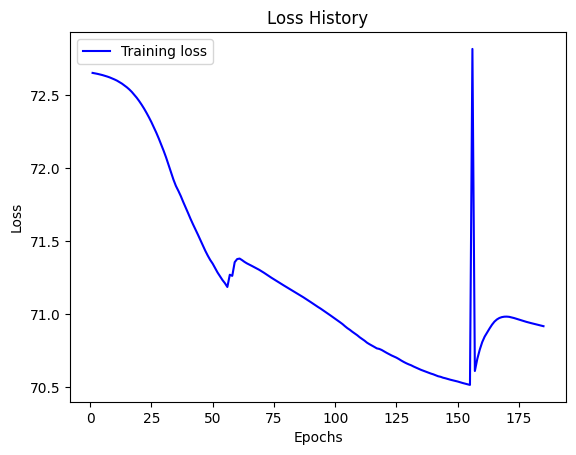

In [ ]:
plot_loss_history(history_2)

In [ ]:
generated_mel_spec = model_2.predict(dataset.take(1))[0]

1/1 [==============================] - 2s 2s/step


In [ ]:
generated_mel_spec = unmerge_frames(generated_mel_spec)

The mel spectrogram is displayed as a spectrogram plot with time on the x-axis and mel frequency on the y-axis. The colorbar indicates the dB scale, and the plot is titled "Mel Spectrogram".

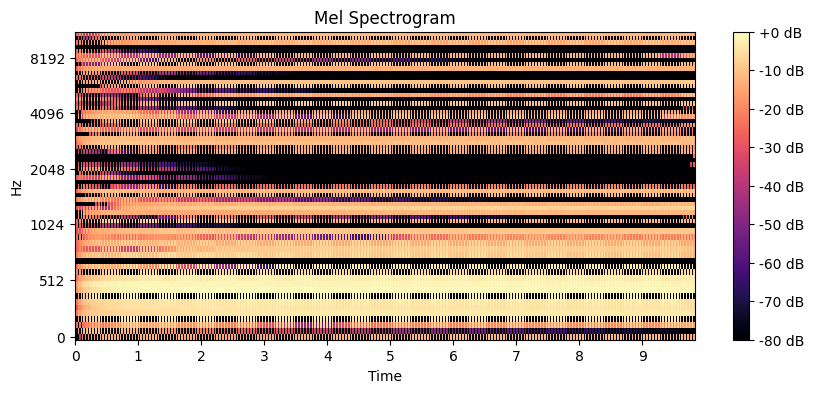

In [ ]:
mel_spec = generated_mel_spec.T
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=22050, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

In [ ]:
import soundfile as sf
linear_spectrogram = librosa.feature.inverse.mel_to_stft(mel_spec)

# Convert linear spectrogram to waveform
waveform = librosa.griffinlim(linear_spectrogram)

# Save waveform as an audio file
sf.write('audio.wav', waveform, samplerate = 22050)

The code snippet defines a function audio_to_melspectrogram that converts an audio file to a mel spectrogram and displays it.

In [ ]:
def audio_to_melspectrogram(audio_path):
    # Load the audio file
    audio, sr = librosa.load(audio_path)

    # Convert the audio to a mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y = audio, sr=sr)

    # Convert to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Print the dimensions of the mel spectrogram
    print("Mel Spectrogram Dimensions:", mel_spec.shape)

    # Display the mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()
    return mel_spec

# TRANSFORMER TTS: One shot Multi speaker text to speech transformer using pretrained scaled speaker embeddings

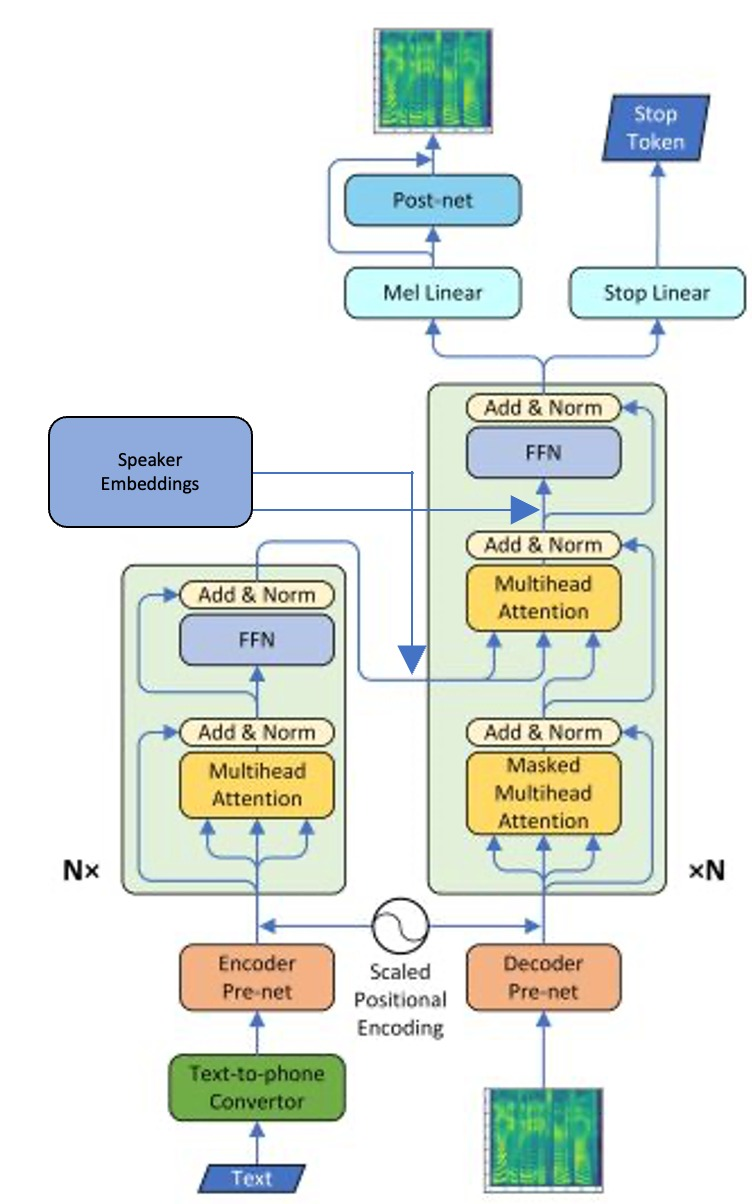

This code implements a multispeaker text to speech transformer that is conditioned onn pretrained speaker emebddings. This allows us to synthesis the same text in different voice and intonations. This is also one shot learning of your voice where you provide small snippet of your voice saying aa sentence. Your voice can then be embedded and this embedding can be used to condition our transformer model will synthesis the mel spectrograms.
lets have a look at the architecture.

###Phonemes
The Text is passed through a phonemizer which captures the pronunciation of the words in the english language. We could have used pretrain word to vec to elmo models but since they were not trained on speech task those embeddings might not be useful.

###Scaled positional embeddings:
We all already know that positional embeddings are very important in tranformer in propogatings the information about the time step. But here both our encoder and our decoder are not in the same time space. So we need to learn a scaling parameter that will scale these positional embeddings for our encoder and decoder seperately.

### Scaled speaker embeddings
The pretrained speaker embeddings are taken from the implementation of this paper:<br>
Here we take these embeddings and scale them so that the model can learn which dimention of the embedding is important for the current task or not. Also this can change from where the speaker embeddings is being propagated. The model may learn a different scaler depending on the position in the network architecture.



###Encoder prenet
The encoder prenet consists of a 1d convolutional layers that can model the interdependencies between the tokens. This is imperative for the tts encoder.

The rest of the model is just like the normal transformer model. Once key detail is the masked multihead attention layer which has a causal maskapplied to it. This causal mask results in it can't look ahead at tokens later in the sequence.

Installing libraries

In [ ]:
!pip install speechbrain
!pip install torch
!pip install transformers
!pip install g2p_en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 44.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torchaudio
from speechbrain.pretrained import EncoderClassifier
from g2p_en import G2p
import tensorflow as tf
import torchaudio
from speechbrain.pretrained import EncoderClassifier
import IPython.display as ipd


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [ ]:

tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
import os
import pandas as pd

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Downloading the speaker encoder pretrained model. This will take audio data and end return an embedding relating to the speaker

In [ ]:
speaker_encoder = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")


Here we extract the melspectograms and the speaker embeddings in the same function

In [ ]:
def extract_mel_speaker_embeddings_from_flac(flac_file_path, speaker_encoder):
  signal, fs =torchaudio.load(flac_file_path)

  audio, sr = librosa.load(flac_file_path)
  mel_spectrogram = librosa.feature.melspectrogram(y = audio, sr=sr)
  speaker_embeddings = speaker_encoder.encode_batch(signal).reshape(-1).numpy()
  return mel_spectrogram, speaker_embeddings


Parsing throught the dataset and processing it the way we want it.

In [ ]:
dataset_dir = '/content/drive/MyDrive/librispeech_data/Data/dev-clean/'


def extract_libri_data(dataset_dir, speaker_encoder = speaker_encoder):
  data = []
  for root, dirs, files in tqdm(os.walk(dataset_dir)):
    for reader in dirs:
      sub_dir = dataset_dir + reader
      for root, chapters, files in os.walk(sub_dir):
        for chapter in chapters:
          chapter_dir = sub_dir + '/' + chapter
          for root, dir, files in os.walk(chapter_dir):
            flac_file_list = []
            text_file = None
            for file in files:
              if file.endswith('.flac'):
                flac_file_list.append(file)
              elif file.endswith('.txt'):
                text_content = open(root + '/' + file, 'r').read()
                lines = text_content.strip().split('\n')
                for line in lines:
                  id_and_words = line.split(' ')
                  id = id_and_words[0]
                  words = ' '.join(id_and_words[1:])
                  flac_dir = os.path.join(root,id +'.flac' )
                  # mel_spectrogram,speaker_embeddings = extract_mel_speaker_embeddings_from_flac(flac_dir, speaker_encoder)
                  data.append([id,flac_dir, words])
  df = pd.DataFrame(data, columns=['id', 'flac_file', 'words'])
  return df


In [ ]:
df = extract_libri_data(dataset_dir)

138it [00:24,  5.72it/s]


In [ ]:
df.head()

id                                          flac_file  \
0  2902-9006-0000  /content/drive/MyDrive/librispeech_data/Data/d...   
1  2902-9006-0001  /content/drive/MyDrive/librispeech_data/Data/d...   
2  2902-9006-0002  /content/drive/MyDrive/librispeech_data/Data/d...   
3  2902-9006-0003  /content/drive/MyDrive/librispeech_data/Data/d...   
4  2902-9006-0004  /content/drive/MyDrive/librispeech_data/Data/d...   

                                               words  
0  ONE WHO WRITES OF SUCH AN ERA LABOURS UNDER A ...  
1  IN THE PRESENT CASE THAT DISADVANTAGE IS DOUBL...  
2  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST S...  
3  THAT DIVINE WORD WHO IS THE LIGHT WHO LIGHTETH...  
4  THE VERY EMPERORS HAD ARRAYED THEMSELVES ON HE...

In [ ]:
flac_files = df.flac_file

In [ ]:
mels = []
speaker_embeddings = []
for file1 in tqdm(flac_files):
  mel , speaker_embedding = extract_mel_speaker_embeddings_from_flac(file1, speaker_encoder)
  mels.append(mel)
  speaker_embeddings.append(speaker_embedding)

  0%|          | 0/2703 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]
100%|██████████| 2703/2703 [19:10<00:00,  2.35it/s]


In [ ]:
df['mels'] = mels
df['speaker_embeddings'] = speaker_embeddings

In [ ]:
df.head()

id                                          flac_file  \
0  2902-9006-0000  /content/drive/MyDrive/librispeech_data/Data/d...   
1  2902-9006-0001  /content/drive/MyDrive/librispeech_data/Data/d...   
2  2902-9006-0002  /content/drive/MyDrive/librispeech_data/Data/d...   
3  2902-9006-0003  /content/drive/MyDrive/librispeech_data/Data/d...   
4  2902-9006-0004  /content/drive/MyDrive/librispeech_data/Data/d...   

                                               words  \
0  ONE WHO WRITES OF SUCH AN ERA LABOURS UNDER A ...   
1  IN THE PRESENT CASE THAT DISADVANTAGE IS DOUBL...   
2  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST S...   
3  THAT DIVINE WORD WHO IS THE LIGHT WHO LIGHTETH...   
4  THE VERY EMPERORS HAD ARRAYED THEMSELVES ON HE...   

                                                mels  \
0  [[0.00010463684, 0.00017393526, 0.00013904324,...   
1  [[5.89907e-05, 0.0003438341, 0.0005722402, 0.0...   
2  [[0.0009018504, 0.00038857007, 0.000814628, 0....   
3  [[9.167408e-05, 6.4725864e-05, 0.00010205967, ...   
4  [[8.531236e-05, 7.509555e-05, 6.5309454e-05, 3...   

                                  speaker_embeddings  
0  [-18.54127, 18.125778, 7.0988293, 12.339268, 1...  
1  [-22.487022, 20.886513, 8.190334, 10.612515, 0...  
2  [-25.529009, 19.744463, 8.719645, 14.4195175, ...  
3  [-21.823488, 18.28045, 5.7897387, 10.832964, 0...  
4  [-20.365034, 16.476946, 8.214504, 12.181861, 0...

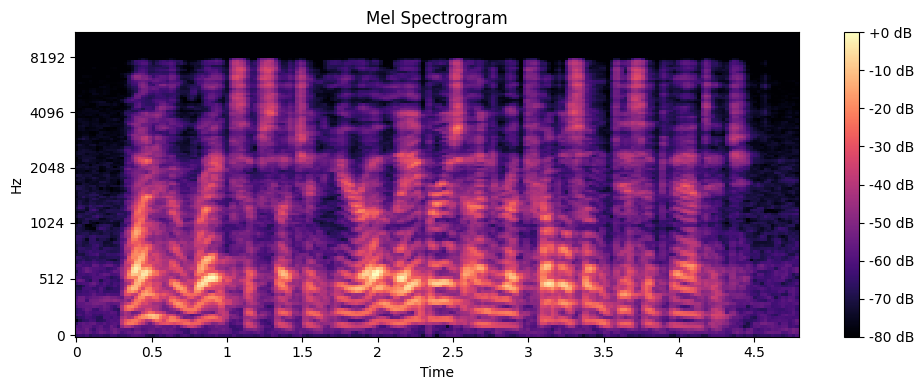

In [ ]:
flac_file = df.flac_file[0]

# Load the audio waveform
audio, sr = librosa.load(flac_file)

# Create the mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y = audio, sr=sr)

# Convert to decibels
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Display the mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

Here we can see the mel spectrogram a piece of audio

In [ ]:


# Path to the FLAC file

audio, sr = librosa.load(flac_file)

# Play the audio
ipd.Audio(data=audio, rate=sr)



and here is the text that is being uttered in that audio

In [ ]:
df.words[0]

'ONE WHO WRITES OF SUCH AN ERA LABOURS UNDER A TROUBLESOME DISADVANTAGE'

This is th text transcipt

Here we you graphenes to phonemes to extract the phoneme from a piee of text. These are groups of words seperated on the basis of how they sound. So they will help out model learn sub wrod sounds so that it can learn how to speak.

In [ ]:
def phoneme_tokenizer(texts):
  g2p = G2p()
  phonemes = list(texts.apply(g2p))
  # print(phonemes)
  phonemes = [[str('<s>'),  *ph , str('</s>')] for ph in phonemes]
  # print(phonemes)
  tokenizer = tf.keras.preprocessing.text.Tokenizer()

  # Fit the tokenizer on the phonemes to generate the vocabulary
  tokenizer.fit_on_texts(phonemes)

  # Convert the phonemes to token sequences
  token_sequences = tokenizer.texts_to_sequences(phonemes)
  return token_sequences , phonemes, tokenizer


In [ ]:
tokens, phonemes, tokenizer = phoneme_tokenizer(df.words)

In [ ]:
df['tokens'] = tokens
df['phonemes'] = phonemes

In [ ]:
df.head()

id                                          flac_file  \
0  2902-9006-0000  /content/drive/MyDrive/librispeech_data/Data/d...   
1  2902-9006-0001  /content/drive/MyDrive/librispeech_data/Data/d...   
2  2902-9006-0002  /content/drive/MyDrive/librispeech_data/Data/d...   
3  2902-9006-0003  /content/drive/MyDrive/librispeech_data/Data/d...   
4  2902-9006-0004  /content/drive/MyDrive/librispeech_data/Data/d...   

                                               words  \
0  ONE WHO WRITES OF SUCH AN ERA LABOURS UNDER A ...   
1  IN THE PRESENT CASE THAT DISADVANTAGE IS DOUBL...   
2  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST S...   
3  THAT DIVINE WORD WHO IS THE LIGHT WHO LIGHTETH...   
4  THE VERY EMPERORS HAD ARRAYED THEMSELVES ON HE...   

                                                mels  \
0  [[0.00010463684, 0.00017393526, 0.00013904324,...   
1  [[5.89907e-05, 0.0003438341, 0.0005722402, 0.0...   
2  [[0.0009018504, 0.00038857007, 0.000814628, 0....   
3  [[9.167408e-05, 6.4725864e-05, 0.00010205967, ...   
4  [[8.531236e-05, 7.509555e-05, 6.5309454e-05, 3...   

                                  speaker_embeddings  \
0  [-18.54127, 18.125778, 7.0988293, 12.339268, 1...   
1  [-22.487022, 20.886513, 8.190334, 10.612515, 0...   
2  [-25.529009, 19.744463, 8.719645, 14.4195175, ...   
3  [-21.823488, 18.28045, 5.7897387, 10.832964, 0...   
4  [-20.365034, 16.476946, 8.214504, 12.181861, 0...   

                                              tokens  \
0  [32, 18, 17, 3, 1, 19, 27, 1, 7, 28, 4, 6, 1, ...   
1  [32, 15, 3, 1, 9, 2, 1, 23, 7, 13, 12, 2, 3, 4...   
2  [32, 3, 26, 4, 1, 25, 22, 1, 10, 4, 1, 13, 20,...   
3  [32, 9, 16, 4, 1, 5, 15, 20, 28, 3, 1, 18, 41,...   
4  [32, 9, 2, 1, 20, 13, 7, 30, 1, 13, 11, 23, 21...   

                                            phonemes  
0  [<s>, W, AH1, N,  , HH, UW1,  , R, AY1, T, S, ...  
1  [<s>, IH0, N,  , DH, AH0,  , P, R, EH1, Z, AH0...  
2  [<s>, N, AA1, T,  , B, IY1,  , IH1, T,  , EH1,...  
3  [<s>, DH, AE1, T,  , D, IH0, V, AY1, N,  , W, ...  
4  [<s>, DH, AH0,  , V, EH1, R, IY0,  , EH1, M, P...

In [ ]:
def plot_melspectrogram(mels):
  mel = np.array(mels).T
  mel_spectrogram_db = librosa.power_to_db(mel, ref=np.max)
  sr = 22050
  # Display the mel spectrogram
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel Spectrogram')
  plt.tight_layout()
  plt.show()


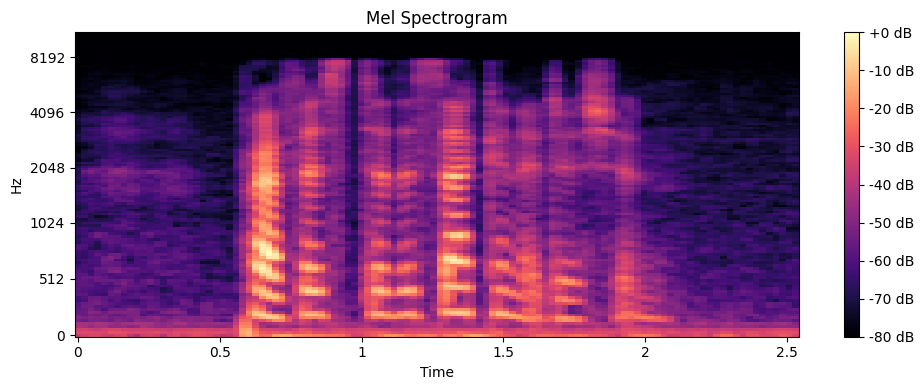

In [ ]:
# Convert to decibels
mel_spectrogram_db = librosa.power_to_db(df.mels[0], ref=np.max)

# Display the mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
tokenizer.word_index

{' ': 1,
 'ah0': 2,
 'n': 3,
 't': 4,
 'd': 5,
 's': 6,
 'r': 7,
 'l': 8,
 'dh': 9,
 'ih1': 10,
 'm': 11,
 'z': 12,
 'eh1': 13,
 'k': 14,
 'ih0': 15,
 'ae1': 16,
 'ah1': 17,
 'w': 18,
 'hh': 19,
 'v': 20,
 'er0': 21,
 'iy1': 22,
 'p': 23,
 'f': 24,
 'b': 25,
 'aa1': 26,
 'uw1': 27,
 'ay1': 28,
 'ao1': 29,
 'iy0': 30,
 'ey1': 31,
 '<s>': 32,
 '</s>': 33,
 'ow1': 34,
 'ng': 35,
 'g': 36,
 'sh': 37,
 'aw1': 38,
 'y': 39,
 'ch': 40,
 'er1': 41,
 'uh1': 42,
 'th': 43,
 'jh': 44,
 'ow0': 45,
 'eh2': 46,
 'ey2': 47,
 'oy1': 48,
 'ih2': 49,
 'eh0': 50,
 'ay2': 51,
 'uw0': 52,
 'ae2': 53,
 'aa2': 54,
 'ow2': 55,
 'ah2': 56,
 'zh': 57,
 'ae0': 58,
 'ao2': 59,
 'uw2': 60,
 'aa0': 61,
 'iy2': 62,
 'ay0': 63,
 'aw2': 64,
 'ao0': 65,
 'uh2': 66,
 'ey0': 67,
 'aw0': 68,
 'er2': 69,
 'uh0': 70,
 'oy2': 71,
 "'": 72}

The mel spectro grams are transposed so that we train on batches and the target mel spectrogram is shifted to the right so that the model ca learn how to predict the next frame

In [ ]:

def process_mel_as_input(mel):
  mel = mel.T
  go_frame = np.full((1,128), 1)
  # pad_frame = np.zeros((1,128))
  stop_frame = np.full((1,128), 2)
  pros_mel = np.concatenate([go_frame,mel])
  return pros_mel
def process_mel_as_target(mel):
    mel = mel.T

    stop_frame = np.full((1,128), 2)
    pros_mel = np.concatenate([mel,stop_frame])
    return pros_mel
# print(df.mels.apply(process_mel_as_input)[0].shape)
# df.mels.apply(process_mel_as_target)[0].shape

In [ ]:
df.tokens.shape

(2703,)

In [ ]:
if 'dataset' in locals():
    del dataset

Takinng all the data and the making a tensorflow dataset from it.

In [ ]:
def process_dataset(x,y):

  padded_x1 = tf.cast(x[0].to_tensor(default_value=0),dtype=tf.float32)
  padded_x2 = tf.cast(x[1].to_tensor(default_value=0),dtype=tf.float32)
  padded_x3 = tf.cast(x[2].to_tensor(default_value=0),dtype=tf.float32)
  padded_y = tf.cast(y.to_tensor(default_value=0),dtype=tf.float32)
  input_text_masks = tf.cast(tf.math.not_equal(padded_x1, 0), dtype=tf.float32)
  input_mel_masks = tf.cast(tf.math.not_equal(padded_x3, 0), dtype=tf.float32)
  stop_tokens = tf.transpose(input_mel_masks, perm = [0,2,1])[:,0,:]
  return (padded_x1,padded_x2,padded_x3, input_text_masks, input_mel_masks), (padded_y,stop_tokens)
# dataset = dataset.map(process_dataset)

In [ ]:
training_perc = 0.8
batch_size = 16
buffer_size = 128
n_data = 128

random_indexes = np.random.randint(0, 2700, size=n_data)


tokens = np.array(df.tokens)[:n_data]
speaker_embeddings = np.array(df.speaker_embeddings)[:n_data]
input_mels = df.mels.apply(process_mel_as_input)[:n_data]
target_mels = df.mels.apply(process_mel_as_target)[:n_data]


tokens_ragged = tf.ragged.constant(tokens)
speaker_embeddings_ragged = tf.ragged.constant(speaker_embeddings)
input_mels_ragged = tf.ragged.constant(input_mels)
target_mels_ragged = tf.ragged.constant(target_mels)

dataset = tf.data.Dataset.from_tensor_slices(((tokens_ragged, speaker_embeddings_ragged, input_mels_ragged), target_mels_ragged))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
dataset = dataset.shuffle(buffer_size).batch(batch_size)

# Split the dataset into training and testing sets


dataset = dataset.map(process_dataset, tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
# for (x1,x2,x3), y in dataset.take(1):
#   print(x1.shape, x2.shape, x3.shape, y.shape)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [ ]:
del df
del tokens
del speaker_embeddings
del input_mels
del target_mels

In [ ]:
del phonemes

In [ ]:
for x,y in dataset.take(1):
  # print(x[0].to_tensor(default_value = 0))
  # eq_pad = x[2].to_tensor(default_value = 0)
  # mask = tf.cast(tf.math.not_equal(eq_pad, 0), dtype=tf.float32)
  # stop_tokens = tf.transpose(mask, perm = [0,2,1])[:,0,:]
  # print(stop_tokens)
  print(x[3].shape, y[0].shape)

(16, 297) (16, 992, 128)


In [ ]:
for x,y in dataset.take(1):
  # print(x[0].to_tensor(default_value = 0))
  # eq_pad = x[2].to_tensor(default_value = 0)
  # mask = tf.cast(tf.math.not_equal(eq_pad, 0), dtype=tf.float32)
  # stop_tokens = tf.transpose(mask, perm = [0,2,1])[:,0,:]
  # print(stop_tokens)

  print(x[0].shape, x[1].shape, x[2].shape,x[3], y[1].shape)

(16, 417) (16, 512) (16, 1382, 128) tf.Tensor(
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]], shape=(16, 417), dtype=float32) (16, 1382)


###Transformer architecture.

In [ ]:
d_model = 512

#####Positional embeddings
These embeddings propagate the positional information of he input token through the network. In oour case we are scalling it through learned parameter since we want the model to learn to allign the time space of the text and the speech.

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

AS you can see here we include a learnable weight and scale each dimension in the embedding.

In [ ]:


class pre_net_scaled_PositionalEmbedding_text(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, num_cnn_layers=3, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)

        self.cnns = [tf.keras.layers.Conv1D(filters=d_model, kernel_size=3, padding='same') for _ in range(num_cnn_layers)]
        self.batch_norms = [tf.keras.layers.BatchNormalization() for _ in range(num_cnn_layers)]
        self.relus = [tf.keras.layers.ReLU() for _ in range(num_cnn_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.linear_projection = tf.keras.layers.Dense(d_model)

        self.pos_encoding = positional_encoding(length=2048, depth=d_model)
        self.scaling_weights = self.add_weight(shape=(1, d_model), initializer="ones", trainable=True)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        # print(tf.shape(x)
        # print(x)
        x = self.embedding(x)

        for cnn, batch_norm, relu in zip(self.cnns, self.batch_norms, self.relus):
            x = cnn(x)
            x = batch_norm(x)
            x = relu(x)
            x = self.dropout(x)

        x = self.linear_projection(x)

        scaling_vector = tf.tile(self.scaling_weights, [length, 1])
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + tf.multiply(scaling_vector, self.pos_encoding[tf.newaxis, :length, :])
        return x


In [ ]:
vocab_size = len(tokenizer.word_index)



Here similarly we define the prenet to hich the positional embedding is added and scalled using a learnable parameter

In [ ]:
class DecoderPreNet(tf.keras.layers.Layer):
    def __init__(self,d_model, hidden_units=d_model):
        super().__init__()
        self.d_model = d_model
        # self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.fc1 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.fc2 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)
        self.scaling_weights = self.add_weight(shape=(1, d_model), initializer="ones", trainable=True)
    # def compute_mask(self, *args, **kwargs):
    #     return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        # x = self.embedding(x)
        x = self.fc1(x)
        x = self.fc2(x)
        length = tf.shape(x)[1]
        # # x = self.embedding(x)
        scaling_vector = tf.tile(self.scaling_weights, [length, 1])
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + tf.multiply(scaling_vector ,  self.pos_encoding[tf.newaxis, :length, :])


        return x

###Attention is all you need

Here we define our base attention layer. This implementation is based off of a few tutorials on the tensorflow tutorials page which was very very helpful for this understanding of this topic.

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

####Cross attention layer
it is the likn between the enocder and the decoder. The context vector tells the decoder which sample to attend to to best predict the next word.

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

#### Self attention layer
Used within the attention blocks to give attentio scores to all other tokens in the sequence

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

In [ ]:
sample_gsa(pre_net(x[0])).shape

TensorShape([32, 349, 512])

In [ ]:
sample_gsa(deprenet(x[2])).shape

TensorShape([32, 978, 512])

###Causal attention
This is what allows the trasformer to be auto regressive ie giving out one prediction at a time
IT achieve it through a causal mask that will prevent it to look ahead in the sequence

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

sample_csa(deprenet(x[2])).shape

TensorShape([32, 978, 512])

####Feed forward layer

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
sample_ffn = FeedForward(512, 1024)

In [ ]:
deprenet(x[2]).shape

TensorShape([32, 978, 512])

In [ ]:
sample_ffn(deprenet(x[2])).shape

TensorShape([32, 978, 512])

####speaker embeddings
This layer adds the pretrained speaker embeddings to differnce parts in the network

In [ ]:
class AddSpeakerEmbedding(tf.keras.layers.Layer):
    def __init__(self,d_model, **kwargs):
        super(AddSpeakerEmbedding, self).__init__(**kwargs)
        self.speaker_scale_weight = self.add_weight(shape=(d_model,), initializer='ones', trainable=True)
        self.add = tf.keras.layers.Add()
    def call(self, inputs, speaker_embedding):
        # Expand dimensions of speaker_embedding to match the shape of inputs
        speaker_embedding_expanded = tf.expand_dims(speaker_embedding, axis=1)

        # Broadcast the speaker_embedding to match the shape of inputs
        speaker_embedding_broadcasted = tf.broadcast_to(speaker_embedding_expanded, tf.shape(inputs))
        scaled_speaker_embedding = speaker_embedding_broadcasted * self.speaker_scale_weight

        return self.add([inputs, scaled_speaker_embedding])



Collating everything in the encoder layer. Notice I added speaker embeddings at the end of the layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)
    self.add_speaker = AddSpeakerEmbedding(d_model)

  def call(self, x, se):
    x = self.self_attention(x)
    x = self.ffn(x)
    x = self.add_speaker(x,se)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model = 512, num_heads = 8, dff = 1024)
sample_encoder_layer(pre_net(x[0]), x[1]).shape

TensorShape([32, 349, 512])

The whole encoder layer
we add the prenet module and the repeat the encoder bock a predifines number of times

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = pre_net_scaled_PositionalEmbedding_text(vocab_size, d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)


  def call(self, x, se):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, se)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
sample_encoder = Encoder(num_layers=2,
                         d_model=512,
                         num_heads=4,
                         dff=1024,
                         vocab_size=72)


In [ ]:
sample_encoder_output = sample_encoder(x[0], x[1])

colating everything on the decoder side and making it a layer so that it called again and again

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)
    self.add_speaker_embedding = AddSpeakerEmbedding(d_model)

  def call(self, x, context, se):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)# Shape `(batch_size, seq_len, d_model)`.
    x = self.add_speaker_embedding(x, se)
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=1024)

sample_decoder_layer_output = sample_decoder_layer(
    x=deprenet(x[2]), context=pre_net(x[0]), se = x[1])

In [ ]:
sample_decoder_layer_output.shape

TensorShape([32, 978, 512])

Making the decoder side of the netwrk

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model

    self.num_layers = num_layers

    self.pos_embedding = DecoderPreNet(d_model, hidden_units=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context, se):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context, se)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores



    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=1024,
                         vocab_size=72)

output = sample_decoder(x[2],sample_encoder_output, x[1])

# Print the shapes.
print(output.shape)

(32, 978, 512)


This post net is pretty interesting. we predict the next frame of the mel spectrogram and we predict a stop token as well

In [ ]:
class Postnet(tf.keras.layers.Layer):

    def __init__(self, mel_channels: int, **kwargs):
        super(Postnet, self).__init__(**kwargs)
        self.mel_channels = mel_channels
        self.stop_linear = tf.keras.layers.Dense(1, activation = 'sigmoid')
        self.mel_out = tf.keras.layers.Dense(mel_channels)

    def call(self, x):
        stop = self.stop_linear(x)
        mel = self.mel_out(x)
        return mel,stop

In [ ]:
sample_post_net = Postnet(128)
mels , stops = sample_post_net(deprenet(x[2]))
mels.shape

TensorShape([32, 978, 128])

Putting it all together in one beautiful transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, mel_channels, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=mel_channels,
                           dropout_rate=dropout_rate)

    self.final_layer = Postnet(mel_channels)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, se, x ,_,_ = inputs

    context = self.encoder(context, se)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context, se)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [ ]:
num_layers = 2
d_model = 512
dff = 128
num_heads = 2
dropout_rate = 0.0
mel_channels = 128

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Setting learning rate

In [ ]:
learning_rate = CustomSchedule(d_model)
learning_rate = 0.00001
# optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
#                                      epsilon=1e-9)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate)

The loss has to be masked since we don't want to calualte loss for paddings which are just xeros

In [ ]:
def masked_mse_loss(label, pred):
  mask = tf.math.not_equal(label, 0)
  mask = tf.cast(mask, dtype=pred.dtype)
  loss = tf.square(label - pred)
  loss *= mask

  loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
  return loss
def weighted_masked_loss(y_true, y_pred, weight_y = 0.65 , weight_stops = 0.35):


    weight_y = weight_y
    weight_stops = 1-weight_y

    loss_y = masked_mse_loss(y_true[0], y_pred[0])
    loss_stops = tf.keras.losses.binary_crossentropy(tf.expand_dims(y_true[1], axis = -1), y_pred[1])

    weighted_loss_y = weight_y * loss_y
    weighted_loss_stops = weight_stops * loss_stops

    total_loss = weighted_loss_y + weighted_loss_stops

    return total_loss

initialising the transformer

In [ ]:
transformer2 = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(tokenizer.word_index),
    mel_channels = mel_channels,
    dropout_rate=dropout_rate)

transformer2.compile(loss=weighted_masked_loss,optimizer=optimizer)

In [ ]:
for x, y in train_dataset.take(1):
  print(x[0])

tf.Tensor(
[32 25 17  4  1 25 28  1  2  3  5  1 25 28  1  9 31  1 14 31 11  1  4 27
  1 11 28  1 18 26 40  1 18 10 40  1 28  1 19 16  5  1 19 10  5  2  3  1
  2 18 31  1 15  3  1  9  2  1 10  3 11 45  6  4  1 23 26 14  2  4  1  9
 16  4  1 28  1 19 16  5  1  2  3  5  1 19 16  5  1 24 21 36 26  4  2  3
  1 18 13  3  1  9 31  1 25 15 36 16  3  1  9 13  7  1  6 41 40 33], shape=(118,), dtype=int32)


In [ ]:
speaker_encoder, tokenizer

###Training

batch_loss 177.53496
batch_loss 236.86484
batch_loss 248.06015
batch_loss 432.5165
batch_loss 213.80956
batch_loss 180.69193
batch_loss 209.41284
batch_loss 206.31497


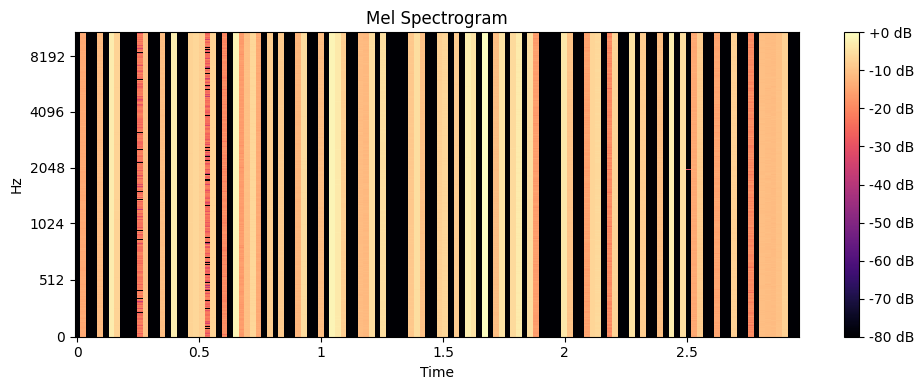

batch_loss 268.773
batch_loss 195.94232
batch_loss 191.05013
batch_loss 197.24696
batch_loss 173.42682
batch_loss 205.56216
batch_loss 387.08658
batch_loss 232.01808
batch_loss 181.23
batch_loss 250.30566
batch_loss 420.76147
batch_loss 213.75612
batch_loss 227.93045
batch_loss 176.50299
batch_loss 239.1673
batch_loss 170.10028
batch_loss 202.38281
batch_loss 171.14131
batch_loss 375.98688
batch_loss 248.69672
batch_loss 208.00636
batch_loss 148.79643
batch_loss 221.91771
batch_loss 185.37791
batch_loss 151.18834
batch_loss 422.1654
batch_loss 157.92818
batch_loss 235.62854
batch_loss 199.59781
batch_loss 170.77203
batch_loss 204.22673
batch_loss 232.4495
batch_loss 440.5222
batch_loss 151.87932
batch_loss 223.03426
batch_loss 177.17833
batch_loss 226.95718
batch_loss 260.93558
batch_loss 153.69481
batch_loss 139.68013
batch_loss 145.2758
batch_loss 198.19443
batch_loss 236.43033
batch_loss 319.21204
batch_loss 191.92046
batch_loss 239.87209
batch_loss 181.62154
batch_loss 204.26149
ba

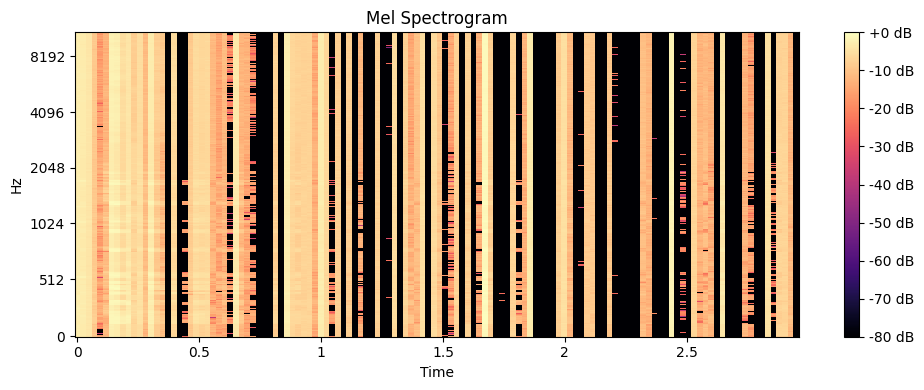

batch_loss 262.03305
batch_loss 224.50624
batch_loss 89.98616
batch_loss 61.037678
batch_loss 147.94641
batch_loss 51.13922
batch_loss 57.200977
batch_loss 65.22576
batch_loss 135.07422
batch_loss 154.3951
batch_loss 130.39464
batch_loss 246.43953
batch_loss 87.89737
batch_loss 60.73201
batch_loss 134.72783
batch_loss 66.46264
batch_loss 69.116806
batch_loss 257.2423
batch_loss 74.019905
batch_loss 63.014248
batch_loss 135.98674
batch_loss 144.61267
batch_loss 116.3902
batch_loss 128.68964
batch_loss 121.17597
batch_loss 262.64133
batch_loss 127.962524
batch_loss 61.168747
batch_loss 63.821438
batch_loss 92.222565
batch_loss 102.88029
batch_loss 197.84312
batch_loss 173.42215
batch_loss 81.86925
batch_loss 139.34172
batch_loss 97.15069
batch_loss 52.272724
batch_loss 228.66687
batch_loss 78.18664
batch_loss 125.446655
batch_loss 84.45935
batch_loss 93.8318
batch_loss 231.53658
batch_loss 49.71145
batch_loss 81.261284
batch_loss 92.290474
batch_loss 282.20245
batch_loss 72.1553
batch_lo

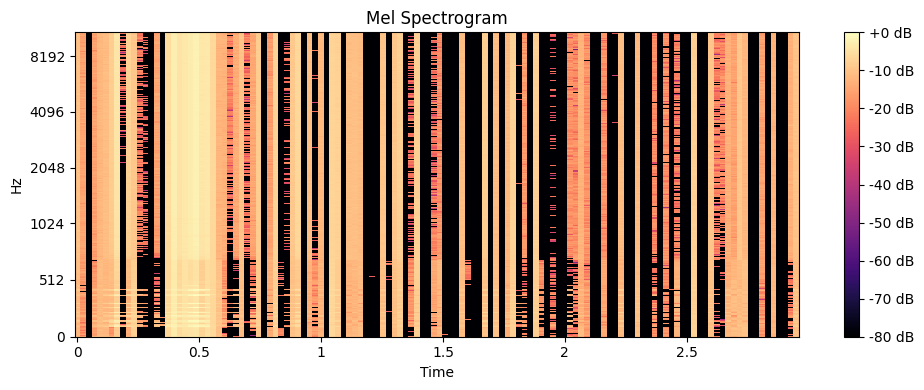

batch_loss 183.89148
batch_loss 308.82764
batch_loss 92.11624
batch_loss 67.7269
batch_loss 119.50164
batch_loss 47.24533
batch_loss 42.486294
batch_loss 95.37907
batch_loss 226.03917
batch_loss 162.17824
batch_loss 96.93383
batch_loss 206.6649
batch_loss 106.06104
batch_loss 38.276558
batch_loss 73.4603
batch_loss 39.489765
batch_loss 90.517845
batch_loss 108.84006
batch_loss 47.435383
batch_loss 43.481087
batch_loss 118.252556
batch_loss 74.47012
batch_loss 92.91102
batch_loss 393.50006
batch_loss 126.68232
batch_loss 56.917767
batch_loss 217.18152
batch_loss 160.34273
batch_loss 103.5605
batch_loss 67.25943
batch_loss 101.70869
batch_loss 87.75349
batch_loss 257.63718
batch_loss 63.70107
batch_loss 34.754303
batch_loss 147.41579
batch_loss 104.296906
batch_loss 52.453365
batch_loss 137.69307
batch_loss 156.04764
batch_loss 118.66207
batch_loss 92.57735
batch_loss 66.936966
batch_loss 84.46227
batch_loss 114.0596
batch_loss 290.17657
batch_loss 39.655807
batch_loss 82.38284
batch_los

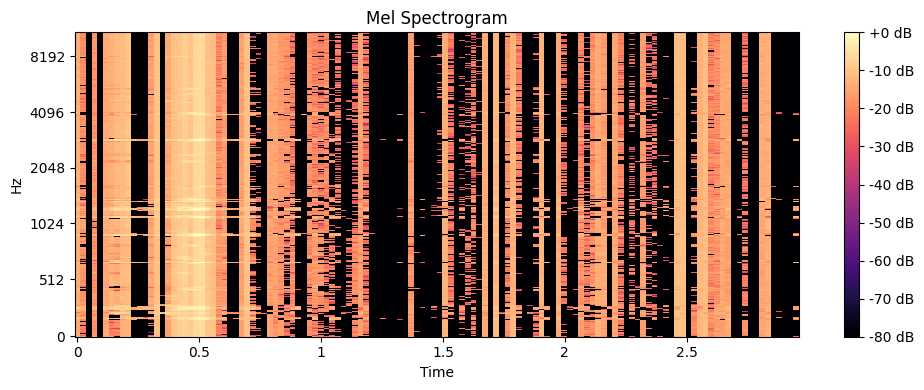

batch_loss 99.624214
batch_loss 100.71766
batch_loss 145.65039
batch_loss 84.7561
batch_loss 83.45159
batch_loss 308.308
batch_loss 32.83264
batch_loss 68.6975
batch_loss 64.120926
batch_loss 87.22585
batch_loss 161.31087
batch_loss 261.647
batch_loss 89.40455
batch_loss 52.087566
batch_loss 96.13483
batch_loss 93.53857
batch_loss 32.947037
batch_loss 74.20746
batch_loss 50.438194
batch_loss 272.8917
batch_loss 71.542885
batch_loss 113.83514
batch_loss 179.0255
batch_loss 47.896297
batch_loss 137.34024
batch_loss 73.02963
batch_loss 176.90796
batch_loss 62.952145
batch_loss 49.73453
batch_loss 94.54231
batch_loss 241.7686
batch_loss 132.4123
batch_loss 43.16289
batch_loss 78.13672
batch_loss 271.81012
batch_loss 103.8571
batch_loss 87.810074
batch_loss 105.53366
batch_loss 124.27532
batch_loss 87.0951
batch_loss 304.27756
batch_loss 49.807224
batch_loss 88.82462
batch_loss 180.65314
batch_loss 48.35449
batch_loss 115.74058
batch_loss 136.33954
batch_loss 64.54385
batch_loss 138.61624
b

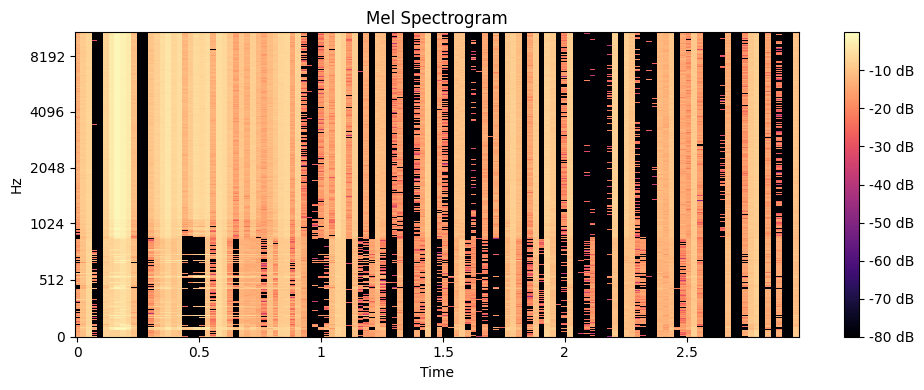

batch_loss 157.63474
batch_loss 63.62572
batch_loss 100.37601
batch_loss 144.10231
batch_loss 49.16502
batch_loss 110.978584
batch_loss 56.152996
batch_loss 244.5164
batch_loss 259.5119
batch_loss 110.103424
batch_loss 56.199257
batch_loss 58.407948
batch_loss 110.43506
batch_loss 62.728218
batch_loss 155.87221
batch_loss 101.8119
batch_loss 65.112976
batch_loss 147.82869
batch_loss 111.87876
batch_loss 33.166267
batch_loss 112.40367
batch_loss 317.29517
batch_loss 67.221344
batch_loss 57.278484
batch_loss 40.68637
batch_loss 86.50375
batch_loss 139.04646
batch_loss 46.880196
batch_loss 69.24568
batch_loss 117.00421
batch_loss 148.36592
batch_loss 265.92728
batch_loss 74.116776
batch_loss 116.155495
batch_loss 94.88356
batch_loss 41.11852
batch_loss 175.57008
batch_loss 210.39186
batch_loss 77.384155
batch_loss 74.2714
batch_loss 61.362923
batch_loss 48.70052
batch_loss 95.963554
batch_loss 250.15334
batch_loss 44.951187
batch_loss 279.28394
batch_loss 45.48389
batch_loss 79.73738
batc

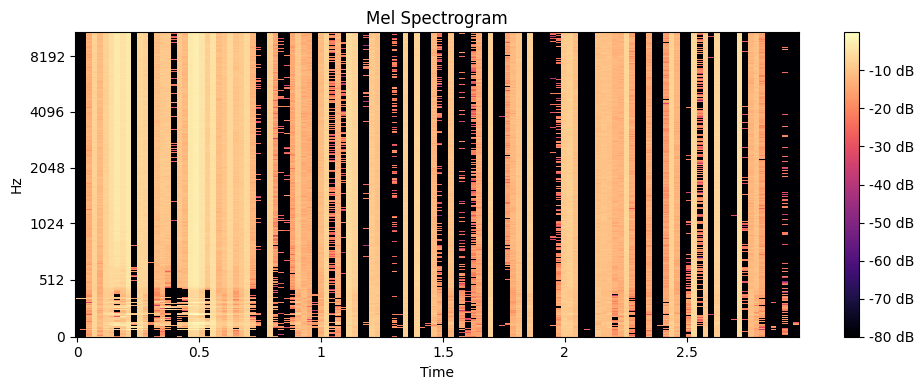

batch_loss 225.53743
batch_loss 128.05829
batch_loss 89.51815
batch_loss 33.120335
batch_loss 87.83056
batch_loss 114.946594
batch_loss 75.34148
batch_loss 125.77854
batch_loss 52.310055
batch_loss 201.64647
batch_loss 108.75461
batch_loss 77.51062
batch_loss 47.770763
batch_loss 92.84914
batch_loss 94.77565
batch_loss 232.38843
batch_loss 43.919537
batch_loss 66.19351
batch_loss 74.455956
batch_loss 144.82733
batch_loss 76.143776
batch_loss 257.83884
batch_loss 57.11318
batch_loss 131.5259
batch_loss 115.74683
batch_loss 126.056274
batch_loss 75.529076
batch_loss 202.95712
batch_loss 78.69591
batch_loss 150.50777
batch_loss 50.90817
batch_loss 70.020096
batch_loss 68.67233
batch_loss 132.90848
batch_loss 88.326035
batch_loss 211.18336
batch_loss 57.782825
batch_loss 86.93593
batch_loss 60.083195
batch_loss 169.1805
batch_loss 215.13373
batch_loss 116.36828
batch_loss 40.466427
batch_loss 105.12603
batch_loss 33.182884
batch_loss 75.49213
batch_loss 106.77887
batch_loss 185.16954
batch

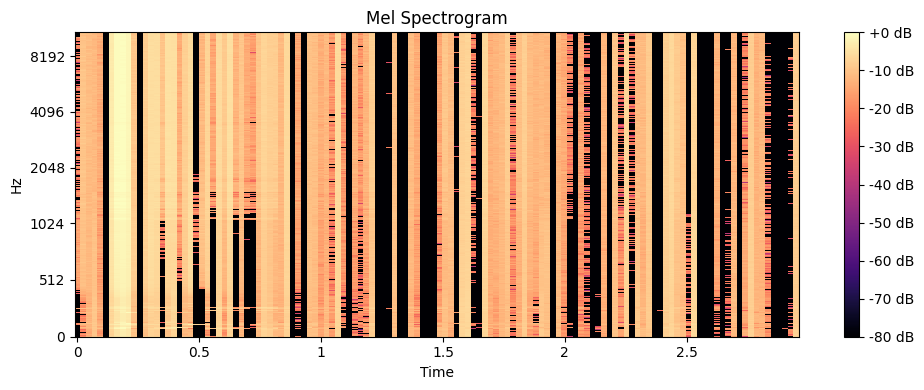

batch_loss 81.26562
batch_loss 300.50507
batch_loss 74.706604
batch_loss 95.09755
batch_loss 12.820378
batch_loss 215.79889
batch_loss 35.20892
batch_loss 86.83588
batch_loss 33.70225
batch_loss 266.3517
batch_loss 96.621155
batch_loss 90.68292
batch_loss 134.68665
batch_loss 58.009995
batch_loss 110.28895
batch_loss 107.74095
batch_loss 103.39706
batch_loss 51.999565
batch_loss 26.001274
batch_loss 118.6967
batch_loss 97.394035
batch_loss 277.11288
batch_loss 124.88384
batch_loss 109.689705
batch_loss 160.34299
batch_loss 77.36536
batch_loss 93.58846
batch_loss 34.377747
batch_loss 286.0119
batch_loss 129.09102
batch_loss 45.897392
batch_loss 75.58896
batch_loss 180.4841
batch_loss 50.581394
batch_loss 169.49252
batch_loss 52.11607
batch_loss 61.16461
batch_loss 115.89637
batch_loss 151.03136
batch_loss 89.23493
batch_loss 79.50517
batch_loss 212.9551
batch_loss 132.34796
batch_loss 56.07833
batch_loss 187.65514
batch_loss 94.76999
batch_loss 32.956272
batch_loss 58.417328
batch_loss 

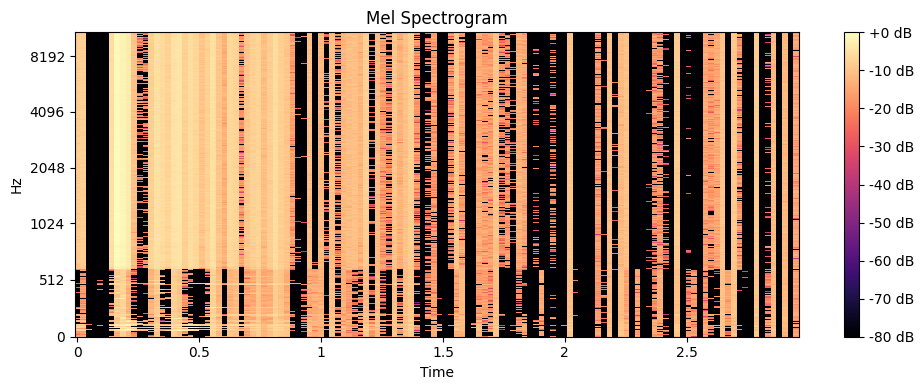

batch_loss 39.03786
batch_loss 101.69307
batch_loss 67.306114
batch_loss 116.86245
batch_loss 37.431805
batch_loss 110.455475
batch_loss 207.99808
batch_loss 165.15935
batch_loss 76.53918
batch_loss 35.29915
batch_loss 285.38486
batch_loss 100.02279
batch_loss 93.66043
batch_loss 166.8607
batch_loss 99.14896
batch_loss 39.536354
batch_loss 136.15182
batch_loss 32.031345
batch_loss 262.52612
batch_loss 62.014336
batch_loss 108.59417
batch_loss 67.29762
batch_loss 93.583275
batch_loss 135.49121
batch_loss 92.62105
batch_loss 252.10127
batch_loss 56.998707
batch_loss 237.38734
batch_loss 58.498993
batch_loss 50.480885
batch_loss 91.90686
batch_loss 128.65723
batch_loss 102.650085
batch_loss 144.59999
batch_loss 65.67967
batch_loss 236.2159
batch_loss 59.93825
batch_loss 86.19281
batch_loss 32.6798
batch_loss 139.36763
batch_loss 55.219707
batch_loss 104.5135
batch_loss 116.97249
batch_loss 338.1088
batch_loss 81.15618
batch_loss 86.63029
batch_loss 71.872185
batch_loss 46.893093
batch_los

KeyboardInterrupt: ignored

In [ ]:
num_epochs = 10000

model = transformer2
# Main training loop
loss_list = []
for epoch in range(num_epochs):
    # # Initialize/reset the metrics
    # train_loss_metric.reset_states()
    # val_loss_metric.reset_states()

    # Training
    for batch, (inputs, targets) in enumerate(dataset):
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model(inputs, training = True)
            # Compute the loss
            # targets.shape
            # print(targets[1].shape)
            # print(predictions[1].shape)
            loss = tf.reduce_mean(weighted_masked_loss(targets, predictions))
            print('batch_loss',loss.numpy())
            loss_list.append(loss.numpy())

        # Compute gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        # Update weights
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
      plot_melspectrogram(np.array(predictions[0][-1]).T)
      # print('saving weights')
      # transformer2.save_weights(f'/content/drive/MyDrive/transformer_weights/loss_{loss.numpy()}.h5', overwrite = True)



batch_loss 55.667618
batch_loss 48.309208
batch_loss 216.09584
batch_loss 113.3164
batch_loss 137.53293
batch_loss 53.453957
batch_loss 57.83049
batch_loss 153.21269


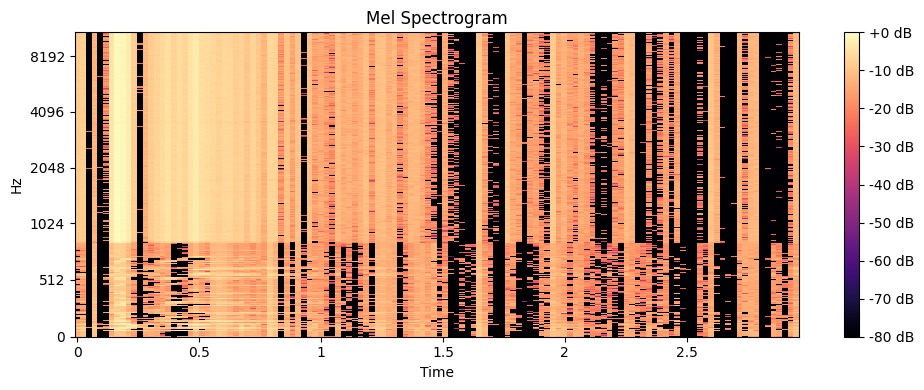

batch_loss 34.44233
batch_loss 109.433
batch_loss 190.65768
batch_loss 78.02497
batch_loss 282.63318
batch_loss 36.292934
batch_loss 60.48353
batch_loss 81.24968
batch_loss 182.56499
batch_loss 69.34071
batch_loss 40.030174
batch_loss 73.66437
batch_loss 88.80559
batch_loss 225.84189
batch_loss 117.06584
batch_loss 65.92284
batch_loss 239.66635
batch_loss 98.36991
batch_loss 74.04419
batch_loss 51.321316
batch_loss 108.54981
batch_loss 63.4474
batch_loss 106.10377
batch_loss 101.08697
batch_loss 63.97977
batch_loss 127.74201
batch_loss 45.961853
batch_loss 246.0224
batch_loss 83.61143
batch_loss 123.72328
batch_loss 105.208984
batch_loss 59.190983
batch_loss 87.14223
batch_loss 235.13579
batch_loss 78.22834
batch_loss 93.6693
batch_loss 117.20548
batch_loss 80.95709
batch_loss 39.282936
batch_loss 175.74298
batch_loss 84.09314
batch_loss 61.063923
batch_loss 59.07802
batch_loss 66.87828
batch_loss 100.045334
batch_loss 74.40646
batch_loss 57.525295
batch_loss 413.28085
batch_loss 258.1

KeyboardInterrupt: ignored

In [ ]:
num_epochs = 1000

model = transformer2
# Main training loop
loss_list = []
for epoch in range(num_epochs):
    # # Initialize/reset the metrics
    # train_loss_metric.reset_states()
    # val_loss_metric.reset_states()

    # Training
    for batch, (inputs, targets) in enumerate(dataset):
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model(inputs, training = True)
            # Compute the loss
            # targets.shape
            # print(targets[1].shape)
            # print(predictions[1].shape)
            loss = tf.reduce_mean(weighted_masked_loss(targets, predictions))
            print('batch_loss',loss.numpy())
            loss_list.append(loss.numpy())

        # Compute gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        # Update weights
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
      plot_melspectrogram(np.array(predictions[0][-1]).T)
      # print('saving weights')
      # transformer2.save_weights(f'/content/drive/MyDrive/transformer weights/loss_{loss.numpy()}.h5', overwrite = True)

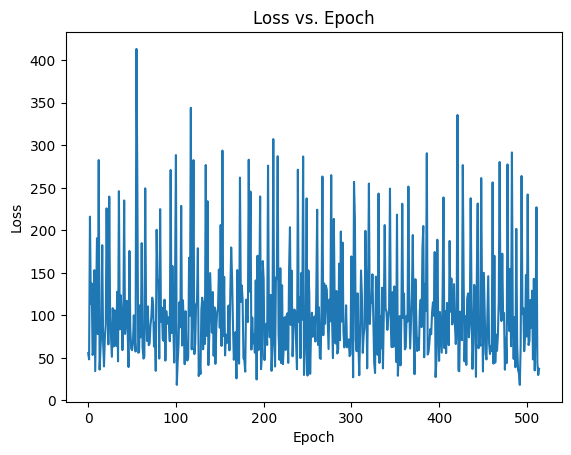

In [ ]:
# Replace this with your actual loss list


# Plot the loss list
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()

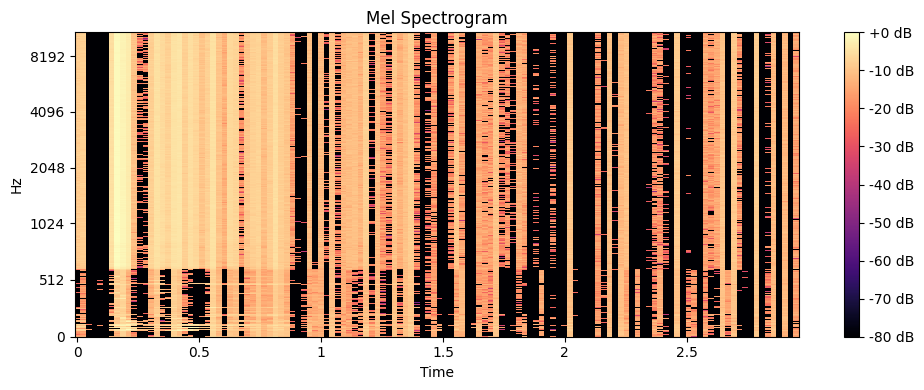

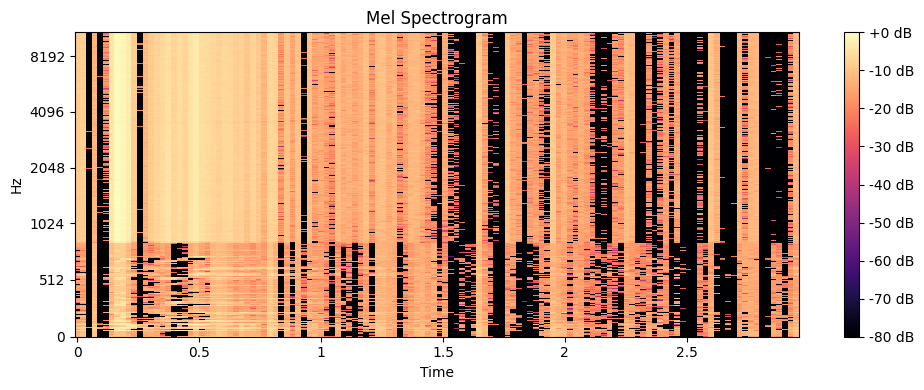

We can see that the mel spectrograms are getting better with every epoch. Even though they arenot intelligible as human speech thay are getting there.

In [ ]:
for x , y in dataset.take(1):
  pass

In [ ]:
melspecs = transformer2(x)[0].numpy()

In [ ]:
!pip install numpy scipy librosa unidecode inflect


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 9.8 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/NVIDIA/waveglow.git


Cloning into 'waveglow'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 193 (delta 0), reused 0 (delta 0), pack-reused 190
Receiving objects: 100% (193/193), 436.79 KiB | 15.60 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [ ]:
%cd waveglow/

/content/waveglow/waveglow


In [ ]:
!wget https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ckpt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth

--2023-06-01 19:52:31--  https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ckpt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 34.223.181.98, 44.226.83.234
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|34.223.181.98|:443... connected.
HTTP request sent, awaiting response... 404 
2023-06-01 19:52:32 ERROR 404: (no description).



In [ ]:
audio_list

audio, sr = librosa.load(flac_file)

# Play the audio
ipd.Audio(data=audio, rate=sr)

for audio in audio_list:
  ipd.Audio(data=audio, rate=22050)


These are the examlples of the generated text. Not itellagible at all.

In [ ]:
ipd.Audio(data=audio_list[9], rate=22050)


In [ ]:
ipd.Audio(data=audio_list[11], rate=22050)

In [ ]:
ipd.Audio(data=audio_list[12], rate=22050)

In [ ]:
ipd.Audio(data=audio_list[15], rate=22050)